## Creating a logistic regression model in Python!

In [356]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [357]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [358]:
ride_ids = ['15692']


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [359]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
print(motion_df)

https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:03.822           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.855           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.888           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.921           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.954           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.987           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.020           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 1

## Drop the NA values from the dataframe:

In [360]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print(motion_df_dropped)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.

## Create an elapsed time field to sync Smartfin data with Video Footage:

In [361]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  
ride_id UTC                                 
15692   2018-11-09 19:16:03.789        0.0  
        2018-11-09 19:16:04.053      252.5  
        2018-11-09 19:16:04.284      501.5  
        2018-11-09 19:16:04.548      753.5  
        2018-11-09 19:16:04.812     1003.5  
        2018-11-09 19:16:05.043     1253.5  
        2018-11-09 19:16:05.307     1504.5  
        2018-11-09 19:16:05.571     1755.5  
        2018-11-09 19:16:05.802     2006.5  
        2018-11-09 19:16:06.066     2258.5

## Sync the velocity info from .FIT files (this example specific to ride_id = 15692): 

In [362]:

##Open file: 
print("Reading file...")
filename = "2018-11-09-11-16-27.csv"
file = open(filename, "r")

acc_x = []
acc_y = []
acc_z = []

gyro_x = []
gyro_y = []
gyro_z = []

mag_x = []
mag_y = []
mag_z = []

distance_14_array = []
speed_14_array = []
altitude_14_array = []
das_14_time = []

distance_0_array = []
speed_0_array = []
altitude_0_array = []
velocity_0_array = []
das_0_time = []

last_sec = 0
last_ms = 0

velocity_x_array = []
velocity_y_array = []
velocity_z_array = []

#Data,10,gyroscope_data,timestamp,"4",s
#Data,11,accelerometer_data,timestamp, "4", s
#Data,12,magnetometer_data,timestamp,"4",s

##Read in lines, append values to arrays:
count = 0
for full_line in file:
    line = full_line.split(',')

    #print(line)

    #Add gyroscope data: 
    if "gyroscope_data" in line: 
        timestamp = line[4]
        gyro_x_vals = line[10].strip('\"')
        for val in gyro_x_vals.split('|'):
            gyro_x.append(val)
        gyro_y_vals = line[13].strip('\"')
        for val in gyro_y_vals.split('|'):
            gyro_y.append(val)
        gyro_z_vals = line[16].strip('\"')
        for val in gyro_z_vals.split('|'):
            gyro_z.append(val)



    #Add accelerometer data: 
    elif ("accelerometer_data" in line): 
        #print("Acc")
        timestamp = line[4]
        acc_x_vals = line[10].strip('\"')
        for val in acc_x_vals.split('|'):
            #print(val)
            acc_x.append(val)
        acc_y_vals = line[13].strip('\"')
        for val in acc_y_vals.split('|'):
            acc_y.append(val)
        acc_z_vals = line[16].strip('\"')
        for val in acc_z_vals.split('|'):
            acc_z.append(val) 

    #Add magnetometer data: 
    elif "magnetometer_data" in line: 
        timestamp = line[4]
        mag_x_vals = line[10].strip('\"')
        for val in mag_x_vals.split('|'):
            mag_x.append(val)
        mag_y_vals = line[13].strip('\"')
        for val in mag_y_vals.split('|'):
            mag_y.append(val)
        mag_z_vals = line[16].strip('\"')
        for val in mag_z_vals.split('|'):
            mag_z.append(val)

    #elif "Data" and "7" and "record" and "distance" and "m" in line: 
        #timestamp = line[3]              ##timestamp in seconds
        #distance = line[6]
        #distance_array.append(distance)  ##distance in meters



    elif ("Data" and "14" and "record" and "m/s") in line:
        #print("Here")
        timestamp = line[4].strip('\"')
        timestamp = int(timestamp)
        position_lat = line[7]
        position_long = line[10]
        distance = line[13]
        enhanced_speed = line[16].strip('\"')        ##enhanced_speed in m/s
        enhanced_alt = line[19]                      ##enhanced_altitude in m 


        if timestamp == last_sec: 
            last_ms += .1
            timestamp = timestamp + last_ms
        else: 
            last_sec = timestamp
            last_ms = 0

        das_14_time.append(timestamp)

        speed_14_array.append(enhanced_speed)
        altitude_14_array.append(enhanced_alt)
        distance_14_array.append(distance)




    elif ("gps_metadata" and "velocity" and "m/s") in line: 
        timestamp = line[4]
        position_lat = line[7]
        position_long = line[10]
        distance = line[13]
        enhanced_speed = line[16]        ##enhanced_speed in m/s
        enhanced_alt = line[19]          ##enhanced_altitude in m 

        velocity = line[28]
        velocity = velocity.strip('\"').split("|")
        if (len(velocity)==3):
            velocity_x = velocity[0]
            velocity_y = velocity[1]
            velocity_z = velocity[2]
            #print(velocity)
            velocity_x_array.append(velocity_x)
            velocity_y_array.append(velocity_y)
            velocity_z_array.append(velocity_z)

        das_0_time.append(timestamp)

        speed_0_array.append(enhanced_speed)
        altitude_0_array.append(enhanced_alt)
        distance_0_array.append(distance)


#Note: need to drop the first value (garbage) from every acc_x, y, z array. 

#file.close()

#print(das_14_time)  #2 x 6s then 10 x all other numbers until maybe end? 
print(len(speed_14_array))
print(len(das_14_time))
print(len(acc_x))
print(len(velocity_x_array))
#print("Speed data: ", speed_14_array)
#print("Time data: ", das_14_time)
zipped = zip(speed_14_array, das_14_time)
print("\n")
print("Zipped Time/Speed data: \n")
for x,y in zipped:
    print(x,y)
#print("Accelerometer Y data: ", acc_y)


    
    

Reading file...
31501
31501
363421
0


Zipped Time/Speed data: 

3.844 6
1.83 6.1
1.374 7
1.181 7.1
0.966 7.2
0.793 7.3
0.793 7.4
0.672 7.5
0.642 7.6
0.543 7.7
0.479 7.8
0.46 7.9
0.449 8
0.511 8.1
0.533 8.2
0.547 8.3
0.541 8.4
0.561 8.5
0.566 8.6
0.568 8.7
0.571 8.8
0.569 8.9
0.562 9
0.543 9.1
0.504 9.2
0.495 9.3
0.463 9.4
0.0 9.5
0.0 9.6
0.0 9.7
0.0 9.8
0.0 9.9
0.0 10
0.0 10.1
0.0 10.2
0.0 10.3
0.0 10.4
0.0 10.5
0.0 10.6
0.0 10.7
0.269 10.8
0.271 10.9
0.274 11
0.28 11.1
0.281 11.2
0.28 11.3
0.276 11.4
0.257 11.5
0.239 11.6
0.225 11.7
0.0 11.8
0.0 11.9
0.0 12
0.0 12.1
0.0 12.2
0.0 12.3
0.0 12.4
0.0 12.5
0.0 12.6
0.0 12.7
0.0 12.8
0.0 12.9
0.0 13
0.233 13.1
0.246 13.2
0.243 13.3
0.266 13.4
0.295 13.5
0.323 13.6
0.35 13.7
0.375 13.8
0.417 13.9
0.435 14
0.427 14.1
0.421 14.2
0.42 14.3
0.402 14.4
0.368 14.5
0.331 14.6
0.293 14.7
0.26 14.8
0.254 14.9
0.24 15
0.224 15.1
0.22 15.2
0.215 15.3
0.0 15.4
0.0 15.5
0.0 15.6
0.0 15.7
0.0 15.8
0.0 16
0.0 16.1
0.0 16.2
0.0 16.3
0.0 16.4
0.0 16.5
0.0 1

0.0 99.8
0.0 100
0.33 100.1
0.36 100.2
0.505 100.3
0.504 100.4
0.774 100.5
0.641 100.6
0.419 100.7
0.0 100.8
0.0 100.9
0.0 101
0.0 101.1
0.0 101.2
0.0 101.3
0.0 101.4
0.0 101.5
0.0 101.6
0.222 101.7
0.248 101.8
0.0 101.9
0.477 102
0.779 102.1
1.447 102.2
1.446 102.3
1.233 102.4
0.905 102.5
0.51 102.6
0.48 102.7
0.445 102.8
0.345 102.9
0.0 103
0.765 103.1
0.478 103.2
0.476 103.3
0.0 103.4
0.0 103.5
0.0 103.6
0.248 103.7
0.398 103.8
0.376 103.9
0.0 104
0.0 104.1
0.0 104.2
0.0 104.3
0.0 104.4
0.0 104.5
0.0 104.6
0.0 104.7
0.292 104.8
0.328 105
1.055 105.1
0.849 105.2
0.84 105.3
1.067 105.4
1.235 105.5
1.116 105.6
1.129 105.7
1.134 105.8
0.643 105.9
0.68 106
0.652 106.1
0.654 106.2
0.653 106.3
0.624 106.4
0.937 106.5
0.457 106.6
0.443 106.7
0.406 106.8
0.617 107
0.738 107.1
1.304 107.2
1.297 107.3
1.094 107.4
1.307 107.5
1.304 107.6
1.287 107.7
1.166 107.8
1.081 107.9
0.981 108
0.952 108.1
0.812 108.2
0.812 108.3
0.814 108.4
0.836 108.5
0.853 108.6
0.872 108.7
1.045 108.8
0.749 108.9
0.774

0.861 189
0.886 189.1
0.658 189.2
0.653 189.3
0.499 189.4
0.491 189.5
0.411 189.6
0.425 189.7
0.413 189.8
0.301 189.9
0.291 190
0.259 190.1
0.228 190.2
0.224 190.3
0.196 190.4
0.176 190.5
0.0 190.6
0.0 190.7
0.0 190.8
0.0 190.9
0.0 191
0.0 191.1
0.0 191.2
0.0 191.3
0.0 191.4
0.0 191.5
0.183 191.6
0.162 191.7
0.165 191.8
0.164 191.9
0.164 192
0.162 192.1
0.159 192.2
0.161 192.3
0.162 192.4
0.167 192.5
0.171 192.6
0.169 192.7
0.162 192.8
0.144 193
0.0 193.1
0.0 193.2
0.0 193.3
0.0 193.4
0.0 193.5
0.0 193.6
0.183 193.7
0.197 193.8
0.0 193.9
0.0 194
0.0 194.1
0.0 194.2
0.0 194.3
0.0 194.4
0.0 194.5
0.0 194.6
0.0 194.7
0.361 194.8
0.0 194.9
0.228 195
0.0 195.1
0.215 195.2
0.205 195.3
0.205 195.4
0.19 195.5
0.186 195.6
0.187 195.7
0.195 195.8
0.0 195.9
0.217 196
0.237 196.1
0.0 196.2
0.233 196.3
0.224 196.4
0.222 196.5
0.219 196.6
0.226 196.7
0.22 196.8
0.208 196.9
0.205 197
0.208 197.1
0.296 197.2
0.289 197.3
0.312 197.4
0.432 197.5
0.279 197.6
0.265 197.7
0.254 197.8
0.245 198
0.262 198.1


1.277 290.1
0.811 290.2
0.802 290.3
0.933 290.4
0.952 290.5
0.985 290.6
1.023 290.7
1.045 290.8
1.074 290.9
1.071 291
0.819 291.1
0.692 291.2
0.69 291.3
0.401 291.4
0.242 291.5
0.0 291.6
0.0 291.7
0.272 291.8
0.269 291.9
0.564 292
0.0 292.1
0.187 292.2
0.187 292.3
0.202 292.4
0.23 292.5
0.231 292.6
0.261 292.7
0.279 292.8
0.19 292.9
0.194 293
0.2 293.1
0.204 293.2
0.196 293.3
0.0 293.4
0.0 293.5
0.0 293.6
0.0 293.7
0.0 293.8
0.0 293.9
0.0 294
0.271 294.1
0.0 294.2
0.0 294.3
0.0 294.4
0.0 294.5
0.198 294.6
0.198 294.7
0.198 294.8
0.213 294.9
0.223 295
0.307 295.1
0.338 295.2
0.336 295.3
0.0 295.4
0.242 295.5
0.244 295.6
0.243 295.7
0.235 295.8
0.235 295.9
0.386 296
0.758 296.1
0.585 296.2
0.579 296.3
0.474 296.4
0.0 296.5
0.265 296.6
0.3 296.7
0.338 296.8
0.351 296.9
0.701 297
1.568 297.1
1.167 297.2
1.166 297.3
1.477 297.4
1.467 297.5
1.439 297.6
1.418 297.7
1.336 297.8
0.708 297.9
0.318 298
0.479 298.1
0.506 298.2
0.504 298.3
0.0 298.4
0.369 298.5
0.507 298.6
0.62 298.7
0.429 298.8
0.

0.0 391.8
0.0 391.9
0.0 392
0.0 392.1
0.0 392.2
0.0 392.3
0.0 392.4
0.21 392.5
0.351 392.6
0.0 392.7
0.0 392.8
0.0 392.9
0.169 393
0.192 393.1
0.275 393.2
0.271 393.3
0.282 393.4
0.0 393.5
0.321 393.6
0.332 393.7
0.0 393.8
0.0 394
0.0 394.1
0.201 394.2
0.196 394.3
0.0 394.4
0.0 394.5
0.0 394.6
0.0 394.7
0.16 394.8
0.152 394.9
0.176 395
0.0 395.1
0.0 395.2
0.0 395.3
0.0 395.4
0.0 395.5
0.0 395.6
0.0 395.7
0.138 395.8
0.281 395.9
0.0 396
0.372 396.1
0.206 396.2
0.205 396.3
0.0 396.4
0.0 396.5
0.0 396.6
0.0 396.7
0.0 396.8
0.155 396.9
0.171 397
0.19 397.1
0.0 397.2
0.0 397.3
0.0 397.4
0.216 397.5
0.242 397.6
0.422 397.7
0.545 397.8
0.662 397.9
0.824 398
0.68 398.1
0.696 398.2
0.69 398.3
0.664 398.4
0.572 398.5
0.406 398.6
0.432 398.7
0.417 398.8
0.404 399
0.389 399.1
0.402 399.2
0.401 399.3
0.592 399.4
0.571 399.5
0.488 399.6
0.61 399.7
0.508 399.8
0.489 399.9
0.462 400
0.252 400.1
0.258 400.2
0.252 400.3
0.247 400.4
0.248 400.5
0.226 400.6
0.207 400.7
0.194 400.8
0.174 400.9
0.0 401
0.0 

0.0 495.8
0.0 496
0.0 496.1
0.0 496.2
0.0 496.3
0.0 496.4
0.0 496.5
0.0 496.6
0.0 496.7
0.0 496.8
0.0 496.9
0.0 497
0.0 497.1
0.0 497.2
0.0 497.3
0.0 497.4
0.283 497.5
0.298 497.6
0.312 497.7
0.32 497.8
0.328 498
0.347 498.1
0.363 498.2
0.355 498.3
0.383 498.4
0.0 498.5
0.0 498.6
0.0 498.7
0.0 498.8
0.0 499
0.0 499.1
0.25 499.2
0.243 499.3
0.391 499.4
0.0 499.5
0.0 499.6
0.192 499.7
0.201 499.8
0.184 499.9
0.204 500
0.0 500.1
0.0 500.2
0.0 500.3
0.366 500.4
0.375 500.5
0.0 500.6
0.267 500.7
0.365 500.8
0.365 501
0.955 501.1
0.0 501.2
0.0 501.3
0.35 501.4
0.65 501.5
0.508 501.6
1.026 501.7
0.756 501.8
0.549 501.9
0.831 502
0.977 502.1
0.97 502.2
0.635 502.3
0.619 502.4
0.784 502.5
0.606 502.6
0.789 502.7
0.643 502.8
1.389 503
0.824 503.1
0.692 503.2
0.69 503.3
1.312 503.4
0.705 503.5
0.624 503.6
0.794 503.7
0.564 503.8
0.787 504
0.966 504.1
0.368 504.2
0.364 504.3
0.552 504.4
0.556 504.5
0.28 504.6
0.248 504.7
0.0 504.8
0.0 504.9
0.239 505
0.365 505.1
0.364 505.2
0.253 505.3
0.395 505.4

1.27 602
1.521 602.1
1.387 602.2
1.381 602.3
1.469 602.4
1.461 602.5
1.439 602.6
1.452 602.7
1.431 602.8
1.402 602.9
1.307 603
1.222 603.1
1.213 603.2
1.392 603.3
1.276 603.4
1.286 603.5
1.302 603.6
1.308 603.7
1.308 603.8
1.3 604
1.317 604.1
1.333 604.2
1.325 604.3
1.2 604.4
0.933 604.5
0.943 604.6
0.774 604.7
0.608 604.8
0.571 605
0.277 605.1
0.45 605.2
0.448 605.3
0.43 605.4
0.395 605.5
0.356 605.6
0.352 605.7
0.377 605.8
0.546 605.9
0.413 606
0.0 606.1
0.0 606.2
0.0 606.3
0.0 606.4
0.189 606.5
0.0 606.6
0.0 606.7
0.0 606.8
0.229 607
0.97 607.1
0.602 607.2
0.597 607.3
0.714 607.4
0.733 607.5
0.637 607.6
0.604 607.7
0.518 607.8
0.39 607.9
0.27 608
0.251 608.1
0.243 608.2
0.343 608.3
0.0 608.4
0.0 608.5
0.0 608.6
0.0 608.7
0.0 608.8
0.0 609
0.145 609.1
0.346 609.2
0.345 609.3
0.236 609.4
0.245 609.5
0.24 609.6
0.0 609.7
0.0 609.8
0.0 609.9
0.0 610
0.0 610.1
0.0 610.2
0.0 610.3
0.0 610.4
0.0 610.5
0.238 610.6
0.26 610.7
0.243 610.8
0.0 611
0.0 611.1
0.0 611.2
0.0 611.3
0.144 611.4
0.0 

0.0 708.5
0.249 708.6
0.284 708.7
0.302 708.8
0.324 709
0.431 709.1
0.0 709.2
0.0 709.3
0.187 709.4
0.293 709.5
0.576 709.6
0.242 709.7
0.236 709.8
0.255 710
0.292 710.1
0.304 710.2
0.299 710.3
0.269 710.4
0.0 710.5
0.171 710.6
0.204 710.7
0.201 710.8
0.0 710.9
0.0 711
0.0 711.1
0.0 711.2
0.0 711.3
0.0 711.4
0.0 711.5
0.0 711.6
0.0 711.7
0.0 711.8
0.0 712
0.0 712.1
0.0 712.2
0.0 712.3
0.0 712.4
0.158 712.5
0.171 712.6
0.178 712.7
0.2 712.8
0.219 712.9
0.0 713
0.0 713.1
0.0 713.2
0.0 713.3
0.0 713.4
0.0 713.5
0.0 713.6
0.227 713.7
0.235 713.8
0.0 713.9
0.0 714
0.0 714.1
0.0 714.2
0.693 714.3
0.0 714.4
0.311 714.5
0.489 714.6
0.831 714.7
0.956 714.8
0.968 715
1.105 715.1
0.99 715.2
0.989 715.3
1.118 715.4
1.091 715.5
1.068 715.6
0.888 715.7
0.735 715.8
0.763 715.9
0.753 716
0.576 716.1
0.569 716.2
0.428 716.3
0.435 716.4
0.418 716.5
0.32 716.6
0.352 716.7
0.389 716.8
0.497 717
1.002 717.1
0.484 717.2
0.476 717.3
0.606 717.4
0.829 717.5
0.719 717.6
0.894 717.7
0.715 717.8
0.918 717.9
0.94

0.977 816.5
0.975 816.6
0.974 816.7
0.993 816.8
1.019 817
1.007 817.1
0.998 817.2
0.804 817.3
0.783 817.4
0.697 817.5
0.681 817.6
0.653 817.7
0.613 817.8
0.533 818
0.516 818.1
0.513 818.2
0.482 818.3
0.445 818.4
0.42 818.5
0.394 818.6
0.357 818.7
0.333 818.8
0.321 819
0.321 819.1
0.328 819.2
0.327 819.3
0.326 819.4
0.32 819.5
0.309 819.6
0.292 819.7
0.0 819.8
0.0 820
0.0 820.1
0.0 820.2
0.0 820.3
0.0 820.4
0.0 820.5
0.446 820.6
0.408 820.7
0.0 820.8
0.0 821
0.363 821.1
0.0 821.2
0.0 821.3
0.0 821.4
0.0 821.5
0.0 821.6
0.0 821.7
0.0 821.8
0.0 822
0.253 822.1
0.264 822.2
0.261 822.3
0.28 822.4
0.288 822.5
0.292 822.6
0.292 822.7
0.295 822.8
0.283 823
0.0 823.1
0.0 823.2
0.0 823.3
0.0 823.4
0.0 823.5
0.0 823.6
0.0 823.7
0.0 823.8
0.0 823.9
0.0 824
0.0 824.1
0.0 824.2
0.0 824.3
0.0 824.4
0.0 824.5
0.0 824.6
0.0 824.7
0.0 824.8
0.0 825
0.225 825.1
0.185 825.2
0.177 825.3
0.0 825.4
0.0 825.5
0.0 825.6
0.0 825.7
0.663 825.8
0.68 826
0.652 826.1
0.323 826.2
0.317 826.3
0.342 826.4
0.356 826.5


2.678 927.1
2.678 927.2
2.882 927.3
3.331 927.4
3.537 927.5
3.793 927.6
2.841 927.7
3.221 928
4.447 928.1
3.745 928.2
3.742 928.3
3.886 928.4
4.202 928.5
4.32 928.6
4.764 928.7
4.898 928.8
4.551 929
4.782 929.1
4.688 929.2
4.684 929.3
4.678 929.4
4.346 929.5
5.063 929.6
4.895 929.7
5.185 929.8
5.188 930
5.189 930.1
4.88 930.2
4.88 930.3
4.797 930.4
4.62 930.5
5.183 930.6
4.389 930.7
4.427 930.8
4.309 931
3.818 931.1
3.705 931.2
3.704 931.3
3.704 931.4
3.472 931.5
3.274 931.6
2.692 931.7
1.869 931.8
1.868 932
3.075 932.1
2.313 932.2
2.305 932.3
2.088 932.4
2.465 932.5
2.444 932.6
2.532 932.7
2.421 932.8
2.178 933
2.441 933.1
2.539 933.2
2.538 933.3
2.676 933.4
2.644 933.5
3.101 933.6
2.941 933.7
2.915 933.8
2.885 934
2.716 934.1
2.715 934.2
3.013 934.3
2.992 934.4
2.998 934.5
2.772 934.6
2.789 934.7
2.798 935
2.8 935.1
2.8 935.2
2.799 935.3
2.797 935.4
2.791 935.5
2.659 935.6
2.646 935.7
2.643 935.8
2.661 936
2.63 936.1
2.415 936.2
2.407 936.3
2.261 936.4
2.052 936.5
1.823 936.6
1.716 9

0.0 1039.4
0.0 1039.5
0.0 1039.6
0.0 1039.7
0.0 1039.8
0.0 1040
0.0 1040.1
0.0 1040.2
0.131 1040.3
0.144 1040.4
0.152 1040.5
0.239 1040.6
0.175 1040.7
0.222 1040.8
0.205 1041
0.0 1041.1
0.0 1041.2
0.0 1041.3
0.124 1041.4
0.16 1041.5
0.312 1041.6
0.442 1041.7
0.288 1042
0.295 1042.1
0.154 1042.2
0.149 1042.3
0.132 1042.4
0.126 1042.5
0.128 1042.6
0.16 1042.7
0.278 1042.8
0.256 1043
0.626 1043.1
0.0 1043.2
0.0 1043.3
0.309 1043.4
0.306 1043.5
0.306 1043.6
0.0 1043.7
0.159 1043.8
0.19 1044
0.438 1044.1
0.32 1044.2
0.317 1044.3
0.468 1044.4
0.388 1044.5
0.666 1044.6
0.234 1044.7
0.364 1044.8
0.375 1045
0.402 1045.1
0.0 1045.2
0.0 1045.3
0.16 1045.4
0.275 1045.5
0.596 1045.6
0.221 1045.7
0.311 1045.8
0.342 1046
0.317 1046.1
0.215 1046.2
0.215 1046.3
0.0 1046.4
0.219 1046.5
0.0 1046.6
0.0 1046.7
0.198 1046.8
0.191 1047
0.174 1047.1
0.151 1047.2
0.149 1047.3
0.0 1047.4
0.256 1047.5
0.226 1047.6
0.31 1047.7
0.331 1047.8
0.301 1048
0.0 1048.1
0.155 1048.2
0.149 1048.3
0.16 1048.4
0.185 1048.5
0

0.271 1123.2
0.271 1123.3
0.273 1123.4
0.283 1123.5
0.322 1123.6
0.0 1123.7
0.245 1123.8
0.25 1124
0.25 1124.1
0.0 1124.2
0.0 1124.3
0.0 1124.4
0.0 1124.5
0.0 1124.6
0.0 1124.7
0.164 1124.8
0.181 1125
0.182 1125.1
0.188 1125.2
0.187 1125.3
0.202 1125.4
0.318 1125.5
0.317 1125.6
0.332 1125.7
0.367 1125.8
0.461 1126
0.309 1126.1
0.299 1126.2
0.299 1126.3
0.0 1126.4
0.192 1126.5
0.193 1126.6
0.205 1126.7
0.228 1126.8
0.32 1127
0.336 1127.1
0.352 1127.2
0.345 1127.3
0.317 1127.4
0.29 1127.5
0.166 1127.6
0.188 1127.7
0.19 1127.8
0.196 1128
0.359 1128.1
0.0 1128.2
0.0 1128.3
0.0 1128.4
0.199 1128.5
0.195 1128.6
0.166 1128.7
0.0 1128.8
0.0 1129
0.0 1129.1
0.0 1129.2
0.0 1129.3
0.0 1129.4
0.0 1129.5
0.0 1129.6
0.0 1129.7
0.0 1129.8
0.0 1130
0.0 1130.1
0.0 1130.2
0.0 1130.3
0.0 1130.4
0.0 1130.5
0.217 1130.6
0.0 1130.7
0.0 1130.8
0.0 1131
0.266 1131.1
0.0 1131.2
0.0 1131.3
0.244 1131.4
0.252 1131.5
0.262 1131.6
0.276 1131.7
0.274 1131.8
0.271 1132
0.0 1132.1
0.0 1132.2
0.0 1132.3
0.0 1132.4
0.0

0.215 1235.5
0.0 1235.6
0.176 1235.7
0.175 1236
0.155 1236.1
0.143 1236.2
0.14 1236.3
0.152 1236.4
0.513 1236.5
0.937 1236.6
0.843 1236.7
0.851 1236.8
0.837 1237
0.585 1237.1
0.589 1237.2
0.588 1237.3
0.565 1237.4
0.469 1237.5
0.239 1237.6
0.537 1237.7
0.354 1237.8
0.391 1238
0.352 1238.1
0.34 1238.2
0.336 1238.3
0.376 1238.4
0.383 1238.5
0.356 1238.6
0.256 1238.7
0.248 1238.8
0.276 1239
0.252 1239.1
0.233 1239.2
0.224 1239.3
0.245 1239.4
0.228 1239.5
0.209 1239.6
0.188 1239.7
0.0 1239.8
0.0 1240
0.0 1240.1
0.0 1240.2
0.0 1240.3
0.0 1240.4
0.0 1240.5
0.0 1240.6
0.0 1240.7
0.0 1241
0.0 1241.1
0.0 1241.2
0.0 1241.3
0.0 1241.4
0.0 1241.5
0.0 1241.6
0.0 1241.7
0.0 1241.8
0.0 1242
0.239 1242.1
0.243 1242.2
0.243 1242.3
0.277 1242.4
0.297 1242.5
0.26 1242.6
0.431 1242.7
0.414 1242.8
0.426 1243
0.334 1243.1
0.374 1243.2
0.373 1243.3
0.408 1243.4
0.565 1243.5
0.539 1243.6
0.506 1243.7
0.466 1243.8
0.322 1244
0.212 1244.1
0.234 1244.2
0.233 1244.3
0.258 1244.4
0.251 1244.5
0.0 1244.6
0.0 1244.7

0.0 1348.3
0.0 1348.4
0.0 1348.5
0.0 1348.6
0.0 1348.7
0.0 1349
0.163 1349.1
0.36 1349.2
0.355 1349.3
0.452 1349.4
0.0 1349.5
0.0 1349.6
0.0 1349.7
0.0 1349.8
0.0 1350
0.0 1350.1
0.0 1350.2
0.0 1350.3
0.0 1350.4
0.152 1350.5
0.158 1350.6
0.163 1350.7
0.162 1350.8
0.167 1351
0.169 1351.1
0.158 1351.2
0.149 1351.3
0.141 1351.4
0.0 1351.5
0.0 1351.6
0.0 1351.7
0.257 1351.8
0.0 1351.9
0.0 1352
0.212 1352.1
0.205 1352.2
0.0 1352.3
0.0 1352.4
0.0 1352.5
0.17 1352.6
0.183 1352.7
0.332 1353
0.503 1353.1
0.711 1353.2
0.709 1353.3
0.687 1353.4
0.822 1353.5
0.819 1353.6
0.943 1353.7
0.825 1353.8
0.794 1354
0.708 1354.1
0.713 1354.2
0.709 1354.3
0.707 1354.4
0.675 1354.5
0.502 1354.6
0.357 1354.7
0.251 1354.8
0.0 1355
0.0 1355.1
0.0 1355.2
0.0 1355.3
0.0 1355.4
0.0 1355.5
0.0 1355.6
0.0 1355.7
0.0 1355.8
0.0 1356
0.0 1356.1
0.0 1356.2
0.182 1356.3
0.167 1356.4
0.165 1356.5
0.165 1356.6
0.173 1356.7
0.154 1356.8
0.145 1357
0.0 1357.1
0.0 1357.2
0.0 1357.3
0.0 1357.4
0.0 1357.5
0.0 1357.6
0.0 1357.7

0.148 1460.5
0.149 1460.6
0.137 1460.7
0.0 1460.8
0.0 1461
0.0 1461.1
0.0 1461.2
0.0 1461.3
0.0 1461.4
0.146 1461.5
0.163 1461.6
0.164 1461.7
0.0 1461.8
0.0 1461.9
0.0 1462
0.0 1462.1
0.0 1462.2
0.0 1462.3
0.132 1462.4
0.16 1462.5
0.0 1462.6
0.0 1462.7
0.174 1462.8
0.206 1463
0.215 1463.1
0.215 1463.2
0.186 1463.3
0.243 1463.4
0.206 1463.5
0.172 1463.6
0.0 1463.7
0.0 1463.8
0.0 1464
0.375 1464.1
0.373 1464.2
0.348 1464.3
0.428 1464.4
0.437 1464.5
0.563 1464.6
0.476 1464.7
0.44 1465
0.0 1465.1
0.0 1465.2
0.0 1465.3
0.0 1465.4
0.0 1465.5
0.0 1465.6
0.0 1465.7
0.0 1465.8
0.0 1466
0.0 1466.1
0.148 1466.2
0.14 1466.3
0.171 1466.4
0.261 1466.5
0.297 1466.6
0.301 1466.7
0.29 1466.8
0.267 1467
0.288 1467.1
0.27 1467.2
0.261 1467.3
0.168 1467.4
0.178 1467.5
0.261 1467.6
0.56 1467.7
0.655 1467.8
0.363 1468
0.378 1468.1
0.373 1468.2
1.241 1468.3
0.521 1468.4
0.355 1468.5
0.389 1468.6
0.493 1468.7
0.373 1469
0.477 1469.1
0.754 1469.2
0.746 1469.3
0.609 1469.4
0.624 1469.5
0.651 1469.6
0.746 1469.7

0.287 1574.6
0.502 1574.7
0.612 1574.8
0.477 1575
0.484 1575.1
0.476 1575.2
0.45 1575.3
0.0 1575.4
0.0 1575.5
0.211 1575.6
0.247 1575.7
0.359 1576
0.216 1576.1
0.248 1576.2
0.243 1576.3
0.265 1576.4
0.29 1576.5
0.257 1576.6
0.23 1576.7
0.237 1576.8
0.0 1577
0.147 1577.1
0.148 1577.2
0.14 1577.3
0.139 1577.4
0.156 1577.5
0.159 1577.6
0.158 1577.7
0.161 1577.8
0.179 1578
0.0 1578.1
0.0 1578.2
0.0 1578.3
0.244 1578.4
0.0 1578.5
0.0 1578.6
0.0 1578.7
0.0 1578.8
0.0 1579
0.237 1579.1
0.233 1579.2
0.0 1579.3
0.0 1579.4
0.0 1579.5
0.215 1579.6
0.0 1579.7
0.0 1580
0.286 1580.1
0.0 1580.2
0.0 1580.3
0.0 1580.4
0.173 1580.5
0.175 1580.6
0.191 1580.7
0.411 1580.8
0.0 1581
0.0 1581.1
0.0 1581.2
0.285 1581.3
0.432 1581.4
0.357 1581.5
0.385 1581.6
0.216 1581.7
0.0 1581.8
0.0 1582
0.401 1582.1
0.401 1582.2
0.0 1582.3
0.0 1582.4
0.205 1582.5
0.373 1582.6
0.238 1582.7
0.0 1583
0.336 1583.1
0.0 1583.2
0.0 1583.3
0.0 1583.4
0.346 1583.5
0.0 1583.6
0.0 1583.7
0.0 1583.8
0.0 1584
0.0 1584.1
0.0 1584.2
0.0 

1.04 1691
0.709 1691.1
0.715 1691.2
0.709 1691.3
2.463 1691.4
2.05 1691.5
1.553 1691.6
1.125 1691.7
0.676 1692
0.649 1692.1
0.647 1692.2
0.644 1692.3
0.65 1692.4
0.673 1692.5
0.78 1692.6
0.772 1692.7
0.744 1692.8
0.661 1693
0.572 1693.1
0.569 1693.2
0.565 1693.3
0.594 1693.4
0.617 1693.5
0.476 1693.6
0.309 1693.7
0.311 1694
0.0 1694.1
0.0 1694.2
0.0 1694.3
0.0 1694.4
0.358 1694.5
0.348 1694.6
0.0 1694.7
0.0 1695
0.0 1695.1
0.0 1695.2
0.0 1695.3
0.272 1695.4
0.305 1695.5
0.436 1695.6
1.343 1695.7
1.487 1695.8
0.994 1696
0.53 1696.1
0.523 1696.2
1.414 1696.3
1.437 1696.4
1.787 1696.5
1.52 1696.6
1.288 1696.7
1.158 1697
0.912 1697.1
0.945 1697.2
0.942 1697.3
0.77 1697.4
0.902 1697.5
0.868 1697.6
0.885 1697.7
0.904 1697.8
1.022 1698
1.041 1698.1
1.036 1698.2
1.237 1698.3
1.213 1698.4
1.106 1698.5
1.105 1698.6
1.321 1698.7
1.347 1699
1.332 1699.1
1.301 1699.2
1.297 1699.3
1.273 1699.4
1.613 1699.5
1.358 1699.6
1.39 1699.7
1.385 1699.8
1.354 1700
1.387 1700.1
1.381 1700.2
1.66 1700.3
1.271 1

0.0 1808.4
0.304 1808.5
0.0 1808.6
0.0 1808.7
0.0 1808.8
0.126 1809
0.139 1809.1
0.131 1809.2
0.257 1809.3
0.258 1809.4
0.0 1809.5
0.298 1809.6
0.0 1809.7
0.0 1810
0.203 1810.1
0.0 1810.2
0.0 1810.3
0.18 1810.4
0.307 1810.5
0.214 1810.6
0.237 1810.7
0.249 1810.8
0.0 1811
0.0 1811.1
0.0 1811.2
0.0 1811.3
0.0 1811.4
0.275 1811.5
0.242 1811.6
0.0 1811.7
0.154 1812
0.194 1812.1
0.0 1812.2
0.0 1812.3
0.0 1812.4
0.179 1812.5
0.0 1812.6
0.0 1812.7
0.169 1812.8
0.209 1813
0.207 1813.1
0.205 1813.2
0.58 1813.3
0.0 1813.4
0.178 1813.5
0.443 1813.6
0.265 1813.7
0.298 1814
0.401 1814.1
0.396 1814.2
0.392 1814.3
0.284 1814.4
0.289 1814.5
0.303 1814.6
0.264 1814.7
0.25 1814.8
0.462 1815
0.0 1815.1
0.0 1815.2
0.0 1815.3
0.165 1815.4
0.0 1815.5
0.0 1815.6
0.426 1815.7
0.0 1816
0.0 1816.1
0.271 1816.2
0.271 1816.3
0.0 1816.4
0.19 1816.5
0.56 1816.6
0.0 1816.7
0.261 1816.8
0.785 1817
0.0 1817.1
0.0 1817.2
0.438 1817.3
0.0 1817.4
0.34 1817.5
0.0 1817.6
0.0 1817.7
0.211 1818
0.447 1818.1
0.0 1818.2
0.0 18

0.181 1926
0.0 1926.1
0.0 1926.2
0.0 1926.3
0.176 1926.4
0.192 1926.5
0.199 1926.6
0.212 1926.7
0.209 1927
0.208 1927.1
0.22 1927.2
0.215 1927.3
0.0 1927.4
0.0 1927.5
0.211 1927.6
0.0 1927.7
0.0 1927.8
0.274 1928
0.0 1928.1
0.196 1928.2
0.196 1928.3
0.298 1928.4
0.28 1928.5
0.221 1928.6
0.234 1928.7
0.261 1929
0.239 1929.1
0.171 1929.2
0.168 1929.3
0.209 1929.4
0.225 1929.5
0.0 1929.6
0.0 1929.7
0.0 1929.8
0.0 1930
0.0 1930.1
0.0 1930.2
0.0 1930.3
0.0 1930.4
0.174 1930.5
0.0 1930.6
0.0 1930.7
0.174 1931
0.18 1931.1
0.182 1931.2
0.177 1931.3
0.183 1931.4
0.167 1931.5
0.164 1931.6
0.152 1931.7
0.16 1931.8
0.393 1932
0.387 1932.1
0.509 1932.2
0.504 1932.3
0.755 1932.4
0.604 1932.5
0.443 1932.6
0.408 1932.7
0.432 1933
0.42 1933.1
0.25 1933.2
0.243 1933.3
0.365 1933.4
0.335 1933.5
0.348 1933.6
0.331 1933.7
0.302 1933.8
0.291 1934
0.28 1934.1
0.268 1934.2
0.261 1934.3
0.254 1934.4
0.239 1934.5
0.226 1934.6
0.205 1934.7
0.193 1935
0.186 1935.1
0.16 1935.2
0.159 1935.3
0.141 1935.4
0.136 1935.

0.209 2044.6
0.179 2044.7
0.147 2044.8
0.128 2045
0.0 2045.1
0.0 2045.2
0.0 2045.3
0.0 2045.4
0.231 2045.5
0.0 2045.6
0.0 2045.7
0.0 2046
0.0 2046.1
0.0 2046.2
0.0 2046.3
0.0 2046.4
0.0 2046.5
0.0 2046.6
0.328 2046.7
0.0 2046.8
0.0 2047
0.251 2047.1
0.243 2047.2
0.0 2047.3
0.0 2047.4
0.163 2047.5
0.0 2047.6
0.0 2047.7
0.488 2048
0.281 2048.1
0.408 2048.2
0.401 2048.3
0.0 2048.4
0.0 2048.5
0.0 2048.6
0.0 2048.7
0.0 2049
0.0 2049.1
0.0 2049.2
0.0 2049.3
0.0 2049.4
0.0 2049.5
0.0 2049.6
0.225 2049.7
0.0 2050
0.0 2050.1
0.157 2050.2
0.149 2050.3
0.0 2050.4
0.154 2050.5
0.271 2050.6
0.178 2050.7
0.141 2050.8
0.224 2051
0.0 2051.1
0.0 2051.2
0.0 2051.3
0.118 2051.4
0.0 2051.5
0.0 2051.6
0.164 2051.7
0.0 2052
0.0 2052.1
0.163 2052.2
0.159 2052.3
0.0 2052.4
0.0 2052.5
0.0 2052.6
0.0 2052.7
0.0 2052.8
0.133 2053
0.0 2053.1
0.0 2053.2
0.668 2053.3
0.233 2053.4
0.257 2053.5
0.0 2053.6
0.0 2053.7
0.263 2054
0.0 2054.1
0.0 2054.2
0.0 2054.3
0.137 2054.4
0.0 2054.5
0.0 2054.6
0.0 2054.7
0.0 2055
0.0

0.336 2194.1
0.247 2194.2
0.243 2194.3
0.0 2194.4
0.0 2194.5
0.0 2194.6
0.229 2194.7
0.0 2195
0.0 2195.1
0.0 2195.2
0.0 2195.3
0.0 2195.4
0.0 2195.5
0.0 2195.6
0.0 2195.7
0.154 2195.8
0.278 2196
0.316 2196.1
0.308 2196.2
0.336 2196.3
0.336 2196.4
0.235 2196.5
0.21 2196.6
0.173 2196.7
0.0 2197
0.0 2197.1
0.143 2197.2
0.14 2197.3
0.397 2197.4
0.201 2197.5
0.196 2197.6
0.0 2197.7
0.119 2198
0.14 2198.1
0.15 2198.2
0.149 2198.3
0.0 2198.4
0.0 2198.5
0.168 2198.6
0.175 2198.7
0.0 2198.8
0.178 2199
0.175 2199.1
0.167 2199.2
0.159 2199.3
0.151 2199.4
0.129 2199.5
0.0 2199.6
0.0 2199.7
0.0 2199.8
0.0 2200
0.0 2200.1
0.0 2200.2
0.0 2200.3
0.179 2200.4
0.188 2200.5
0.227 2200.6
0.389 2200.7
0.395 2200.8
0.365 2201
0.261 2201.1
0.252 2201.2
0.279 2201.3
0.272 2201.4
0.0 2201.5
0.0 2201.6
0.0 2201.7
0.0 2202
0.0 2202.1
0.0 2202.2
0.0 2202.3
0.0 2202.4
0.121 2202.5
0.132 2202.6
0.146 2202.7
0.306 2202.8
0.21 2203
0.0 2203.1
0.0 2203.2
0.189 2203.3
0.207 2203.4
0.234 2203.5
0.223 2203.6
0.204 2203.7

0.723 2276.4
0.693 2276.5
0.674 2276.6
0.862 2276.7
0.878 2277
0.866 2277.1
0.776 2277.2
0.774 2277.3
0.792 2277.4
0.873 2277.5
0.736 2277.6
0.7 2277.7
0.608 2277.8
0.607 2278
0.736 2278.1
0.728 2278.2
0.823 2278.3
0.648 2278.4
0.629 2278.5
0.723 2278.6
0.887 2278.7
0.848 2279
0.719 2279.1
0.732 2279.2
0.728 2279.3
0.73 2279.4
0.922 2279.5
0.834 2279.6
0.844 2279.7
0.705 2279.8
1.01 2280
1.104 2280.1
1.101 2280.2
0.965 2280.3
0.945 2280.4
0.985 2280.5
1.169 2280.6
1.322 2280.7
1.405 2281
1.547 2281.1
1.54 2281.2
1.585 2281.3
1.889 2281.4
2.045 2281.5
2.261 2281.6
2.088 2281.7
2.277 2282
2.745 2282.1
2.738 2282.2
2.734 2282.3
3.065 2282.4
3.169 2282.5
2.957 2282.6
2.926 2282.7
2.915 2282.8
2.945 2283
3.084 2283.1
3.079 2283.2
3.088 2283.3
3.066 2283.4
2.919 2283.5
2.799 2283.6
2.579 2283.7
2.39 2284
2.399 2284.1
2.398 2284.2
2.037 2284.3
2.019 2284.4
1.672 2284.5
0.769 2284.6
0.994 2284.7
0.637 2285
0.643 2285.1
0.63 2285.2
0.625 2285.3
0.0 2285.4
0.357 2285.5
0.24 2285.6
0.259 2285.7
0

0.592 2405.4
0.615 2405.5
0.594 2405.6
0.678 2405.7
1.024 2406
0.628 2406.1
0.625 2406.2
0.962 2406.3
0.618 2406.4
1.212 2406.5
0.72 2406.6
0.882 2406.7
1.222 2407
0.875 2407.1
0.854 2407.2
0.849 2407.3
0.362 2407.4
0.563 2407.5
0.841 2407.6
0.473 2407.7
0.827 2408
0.589 2408.1
0.588 2408.2
0.849 2408.3
0.586 2408.4
0.721 2408.5
1.084 2408.6
0.701 2408.7
0.834 2409
1.105 2409.1
0.596 2409.2
0.588 2409.3
0.956 2409.4
0.374 2409.5
0.932 2409.6
1.329 2409.7
0.535 2409.8
0.928 2410
1.245 2410.1
1.241 2410.2
0.542 2410.3
0.882 2410.4
1.33 2410.5
0.583 2410.6
0.781 2410.7
1.18 2411
0.487 2411.1
0.485 2411.2
0.849 2411.3
0.557 2411.4
1.082 2411.5
0.525 2411.6
0.775 2411.7
1.069 2412
0.537 2412.1
0.811 2412.2
0.532 2412.3
0.487 2412.4
0.745 2412.5
1.023 2412.6
0.488 2412.7
0.658 2413
0.976 2413.1
0.446 2413.2
0.439 2413.3
0.756 2413.4
0.538 2413.5
0.69 2413.6
0.847 2413.7
0.728 2414
0.691 2414.1
0.717 2414.2
0.709 2414.3
0.754 2414.4
0.586 2414.5
0.581 2414.6
0.444 2414.7
0.587 2415
0.35 2415.

0.0 2528.3
0.322 2528.4
0.34 2528.5
0.559 2528.6
0.677 2528.7
0.576 2529
0.229 2529.1
0.372 2529.2
0.364 2529.3
0.376 2529.4
0.392 2529.5
0.27 2529.6
0.273 2529.7
0.307 2529.8
0.335 2530
0.568 2530.1
0.56 2530.2
0.579 2530.3
0.933 2530.4
1.322 2530.5
1.035 2530.6
0.934 2530.7
0.454 2531
0.721 2531.1
1.337 2531.2
1.334 2531.3
1.138 2531.4
1.166 2531.5
1.193 2531.6
1.03 2531.7
0.798 2532
0.658 2532.1
0.0 2532.2
0.0 2532.3
0.241 2532.4
0.203 2532.5
0.228 2532.6
0.676 2532.7
0.595 2533
0.571 2533.1
0.354 2533.2
0.345 2533.3
0.39 2533.4
0.414 2533.5
0.55 2533.6
0.529 2533.7
0.388 2534
0.415 2534.1
0.516 2534.2
0.513 2534.3
0.516 2534.4
0.491 2534.5
0.465 2534.6
0.45 2534.7
0.443 2535
0.581 2535.1
0.486 2535.2
0.485 2535.3
0.505 2535.4
0.699 2535.5
0.73 2535.6
0.698 2535.7
0.712 2536
0.725 2536.1
0.729 2536.2
0.728 2536.3
0.86 2536.4
0.764 2536.5
0.777 2536.6
0.806 2536.7
0.896 2537
0.9 2537.1
0.904 2537.2
0.896 2537.3
1.144 2537.4
1.139 2537.5
1.227 2537.6
1.376 2537.7
1.512 2538
1.899 2538

1.389 2621.4
1.369 2621.5
1.378 2621.6
1.371 2621.7
1.363 2621.8
1.355 2622
1.49 2622.1
1.484 2622.2
1.454 2622.3
1.314 2622.4
1.195 2622.5
1.012 2622.6
0.879 2623
0.69 2623.1
0.451 2623.2
0.448 2623.3
0.0 2623.4
0.0 2623.5
0.0 2623.6
0.301 2623.7
0.318 2624
0.355 2624.1
0.391 2624.2
0.383 2624.3
0.0 2624.4
0.0 2624.5
0.0 2624.6
0.0 2624.7
0.0 2625
0.0 2625.1
0.0 2625.2
0.0 2625.3
0.0 2625.4
0.0 2625.5
0.0 2625.6
0.0 2625.7
0.0 2626
0.0 2626.1
0.0 2626.2
0.0 2626.3
0.0 2626.4
0.288 2626.5
0.307 2626.6
0.389 2626.7
0.603 2627
0.367 2627.1
0.382 2627.2
0.373 2627.3
0.399 2627.4
0.421 2627.5
0.418 2627.6
0.402 2627.7
0.524 2628
0.793 2628.1
0.627 2628.2
0.625 2628.3
0.625 2628.4
0.639 2628.5
0.605 2628.6
0.394 2628.7
0.423 2629
0.401 2629.1
0.492 2629.2
0.485 2629.3
0.832 2629.4
0.629 2629.5
0.818 2629.6
1.059 2629.7
0.92 2630
0.907 2630.1
0.877 2630.2
0.877 2630.3
0.685 2630.4
0.598 2630.5
0.579 2630.6
0.458 2630.7
0.454 2631
0.368 2631.1
0.344 2631.2
0.336 2631.3
0.31 2631.4
0.0 2631.5


0.581 2714.5
0.47 2714.6
0.434 2714.7
0.271 2715
0.273 2715.1
0.24 2715.2
0.233 2715.3
0.337 2715.4
0.0 2715.5
0.0 2715.6
0.0 2715.7
0.526 2715.8
0.392 2716
1.163 2716.1
1.157 2716.2
0.576 2716.3
0.721 2716.4
1.283 2716.5
0.532 2716.6
0.409 2716.7
0.881 2717
0.0 2717.1
0.846 2717.2
0.84 2717.3
0.419 2717.4
1.122 2717.5
0.446 2717.6
0.468 2717.7
0.884 2718
0.249 2718.1
0.346 2718.2
0.345 2718.3
0.0 2718.4
0.215 2718.5
0.688 2718.6
0.0 2718.7
0.0 2719
0.505 2719.1
0.0 2719.2
0.0 2719.3
0.0 2719.4
0.41 2719.5
0.87 2719.6
0.463 2719.7
0.0 2719.8
0.209 2720
0.227 2720.1
0.224 2720.2
0.243 2720.3
0.0 2720.4
0.227 2720.5
0.252 2720.6
0.0 2721
0.158 2721.1
0.15 2721.2
0.149 2721.3
0.149 2721.4
0.186 2721.5
0.0 2721.6
0.209 2721.7
0.221 2722
0.368 2722.1
0.0 2722.2
0.0 2722.3
0.285 2722.4
0.0 2722.5
0.166 2722.6
0.463 2722.7
0.208 2723
0.234 2723.1
0.0 2723.2
0.0 2723.3
0.219 2723.4
0.231 2723.5
0.215 2723.6
0.56 2723.7
0.224 2724
0.541 2724.1
0.318 2724.2
0.317 2724.3
0.822 2724.4
0.82 2724.5


3.804 2868.6
3.504 2868.7
3.817 2869
3.114 2869.1
2.609 2869.2
2.603 2869.3
1.674 2869.4
1.575 2869.5
1.338 2869.6
0.979 2869.7
0.853 2870
0.645 2870.1
0.551 2870.2
0.551 2870.3
0.514 2870.4
0.382 2870.5
0.368 2870.6
0.332 2870.7
0.294 2870.8
0.29 2871
0.449 2871.1
0.448 2871.2
1.147 2871.3
3.621 2871.4
0.933 2871.5
1.657 2871.6
2.068 2871.7
1.341 2872
1.148 2872.1
1.148 2872.2
1.174 2872.3
1.144 2872.4
0.937 2872.5
0.938 2872.6
0.8 2872.7
0.771 2873
0.771 2873.1
0.758 2873.2
0.756 2873.3
0.847 2873.4
0.947 2873.5
1.107 2873.6
1.256 2873.7
1.502 2874
1.541 2874.1
1.087 2874.2
1.082 2874.3
0.895 2874.4
1.31 2874.5
1.558 2874.6
1.978 2874.7
2.463 2874.8
2.287 2875
1.994 2875.1
1.987 2875.2
2.002 2875.3
1.756 2875.4
1.292 2875.5
1.552 2875.6
1.431 2875.7
1.269 2876
1.427 2876.1
0.84 2876.2
0.84 2876.3
0.975 2876.4
0.95 2876.5
0.797 2876.6
0.627 2876.7
0.534 2877
0.33 2877.1
0.0 2877.2
0.0 2877.3
0.0 2877.4
0.307 2877.5
0.342 2877.6
0.36 2877.7
0.367 2878
0.0 2878.1
0.0 2878.2
0.0 2878.3
0

0.282 2993.1
0.0 2993.2
0.0 2993.3
0.506 2993.4
0.0 2993.5
0.183 2993.6
0.782 2993.7
0.383 2994
0.392 2994.1
0.496 2994.2
0.495 2994.3
0.376 2994.4
0.686 2994.5
0.0 2994.6
0.517 2994.7
0.283 2995
0.2 2995.1
0.41 2995.2
0.401 2995.3
0.313 2995.4
0.326 2995.5
0.364 2995.6
0.381 2995.7
0.397 2996
0.316 2996.1
0.327 2996.2
0.317 2996.3
0.335 2996.4
0.366 2996.5
0.398 2996.6
0.221 2996.7
0.514 2997
0.503 2997.1
0.661 2997.2
0.653 2997.3
0.429 2997.4
0.676 2997.5
0.474 2997.6
0.0 2997.7
0.188 2998
0.182 2998.1
0.216 2998.2
0.215 2998.3
0.451 2998.4
0.48 2998.5
0.5 2998.6
0.351 2998.7
0.557 2999
0.669 2999.1
0.671 2999.2
0.662 2999.3
0.0 2999.4
0.228 2999.5
0.219 2999.6
0.0 2999.7
0.147 3000
0.244 3000.1
0.0 3000.2
0.0 3000.3
0.0 3000.4
0.167 3000.5
0.182 3000.6
0.0 3000.7
0.0 3001
0.0 3001.1
0.0 3001.2
0.0 3001.3
0.0 3001.4
0.0 3001.5
0.0 3001.6
0.307 3001.7
0.0 3002
0.177 3002.1
0.167 3002.2
0.159 3002.3
0.315 3002.4
0.0 3002.5
0.0 3002.6
0.409 3002.7
0.0 3003
0.183 3003.1
0.0 3003.2
0.0 30

0.356 3086.7
0.0 3087
0.265 3087.1
0.0 3087.2
0.0 3087.3
0.0 3087.4
0.0 3087.5
0.0 3087.6
0.451 3087.7
0.0 3088
0.258 3088.1
0.0 3088.2
0.0 3088.3
0.321 3088.4
0.0 3088.5
0.212 3088.6
0.711 3088.7
0.262 3089
0.36 3089.1
0.0 3089.2
0.0 3089.3
0.384 3089.4
0.0 3089.5
0.166 3089.6
0.341 3089.7
0.0 3090
0.0 3090.1
0.0 3090.2
0.0 3090.3
0.265 3090.4
0.283 3090.5
0.552 3090.6
0.64 3090.7
0.855 3091
0.867 3091.1
0.88 3091.2
0.877 3091.3
0.774 3091.4
0.791 3091.5
0.787 3091.6
0.695 3091.7
0.473 3092
0.457 3092.1
0.326 3092.2
0.317 3092.3
0.0 3092.4
0.195 3092.5
0.185 3092.6
0.0 3092.7
0.0 3093
0.0 3093.1
0.0 3093.2
0.0 3093.3
0.0 3093.4
0.0 3093.5
0.0 3093.6
0.19 3093.7
0.171 3094
0.174 3094.1
0.166 3094.2
0.159 3094.3
0.159 3094.4
0.151 3094.5
0.157 3094.6
0.173 3094.7
0.0 3095
0.166 3095.1
0.0 3095.2
0.0 3095.3
0.0 3095.4
0.0 3095.5
0.0 3095.6
0.218 3095.7
0.0 3096
0.0 3096.1
0.0 3096.2
0.0 3096.3
0.179 3096.4
0.0 3096.5
0.0 3096.6
0.282 3096.7
0.276 3097
0.0 3097.1
0.0 3097.2
0.0 3097.3
0.3

0.95 3180.6
1.207 3180.7
0.929 3181
0.904 3181.1
0.888 3181.2
0.886 3181.3
1.125 3181.4
1.037 3181.5
1.151 3181.6
1.293 3181.7
0.981 3182
1.141 3182.1
1.133 3182.2
1.129 3182.3
1.327 3182.4
1.194 3182.5
1.226 3182.6
1.232 3182.7
1.232 3183
1.229 3183.1
1.247 3183.2
1.241 3183.3
1.245 3183.4
1.227 3183.5
1.027 3183.6
1.023 3183.7
1.02 3184
1.011 3184.1
0.982 3184.2
0.98 3184.3
0.959 3184.4
0.785 3184.5
0.762 3184.6
0.77 3184.7
0.742 3185
0.768 3185.1
0.582 3185.2
0.579 3185.3
0.705 3185.4
0.543 3185.5
0.582 3185.6
0.558 3185.7
0.474 3186
0.504 3186.1
0.48 3186.2
0.476 3186.3
0.696 3186.4
0.551 3186.5
0.531 3186.6
0.712 3186.7
0.313 3187
0.494 3187.1
0.386 3187.2
0.383 3187.3
0.535 3187.4
0.447 3187.5
0.536 3187.6
0.809 3187.7
0.799 3188
0.836 3188.1
0.834 3188.2
0.83 3188.3
0.944 3188.4
0.936 3188.5
1.03 3188.6
1.056 3188.7
0.915 3189
0.929 3189.1
1.08 3189.2
1.073 3189.3
1.31 3189.4
1.279 3189.5
1.255 3189.6
1.347 3189.7
1.242 3190
1.479 3190.1
1.342 3190.2
1.334 3190.3
1.43 3190.4
1.3

0.321 3305.4
0.407 3305.5
0.378 3305.6
0.416 3305.7
0.795 3306
0.36 3306.1
0.548 3306.2
0.541 3306.3
0.253 3306.4
0.416 3306.5
0.0 3306.6
0.0 3306.7
0.136 3307
0.0 3307.1
0.0 3307.2
0.0 3307.3
0.0 3307.4
0.0 3307.5
0.0 3307.6
0.0 3307.7
0.0 3308
0.0 3308.1
0.0 3308.2
0.0 3308.3
0.0 3308.4
0.0 3308.5
0.204 3308.6
0.241 3308.7
0.0 3309
0.301 3309.1
0.273 3309.2
0.271 3309.3
0.242 3309.4
0.218 3309.5
0.0 3309.6
0.288 3309.7
0.0 3310
0.0 3310.1
0.0 3310.2
0.0 3310.3
0.196 3310.4
0.179 3310.5
0.173 3310.6
0.2 3310.7
0.0 3311
0.186 3311.1
0.18 3311.2
0.177 3311.3
0.172 3311.4
0.161 3311.5
0.158 3311.6
0.153 3311.7
0.0 3312
0.0 3312.1
0.0 3312.2
0.0 3312.3
0.0 3312.4
0.0 3312.5
0.0 3312.6
0.173 3312.7
0.168 3313
0.194 3313.1
0.209 3313.2
0.205 3313.3
0.471 3313.4
0.438 3313.5
0.474 3313.6
0.871 3313.7
0.611 3314
0.82 3314.1
0.503 3314.2
0.495 3314.3
0.485 3314.4
0.316 3314.5
0.199 3314.6
0.178 3314.7
0.159 3315
0.162 3315.1
0.155 3315.2
0.149 3315.3
0.157 3315.4
0.151 3315.5
0.154 3315.6
0.29

0.355 3430.3
0.767 3430.4
0.389 3430.5
0.385 3430.6
1.199 3430.7
0.517 3431
0.326 3431.1
0.21 3431.2
0.205 3431.3
0.225 3431.4
0.212 3431.5
0.236 3431.6
0.757 3431.7
0.464 3432
0.348 3432.1
0.0 3432.2
0.0 3432.3
0.49 3432.4
0.0 3432.5
0.0 3432.6
0.612 3432.7
0.299 3433
0.473 3433.1
0.352 3433.2
0.345 3433.3
0.439 3433.4
0.278 3433.5
0.238 3433.6
0.708 3433.7
0.426 3434
0.743 3434.1
0.576 3434.2
0.569 3434.3
0.805 3434.4
0.551 3434.5
0.793 3434.6
0.46 3434.7
0.49 3435
1.086 3435.1
0.663 3435.2
0.662 3435.3
0.977 3435.4
0.727 3435.5
0.749 3435.6
1.513 3435.7
0.886 3436
1.036 3436.1
0.739 3436.2
0.737 3436.3
1.342 3436.4
0.814 3436.5
0.909 3436.6
1.786 3436.7
1.08 3437
1.33 3437.1
1.193 3437.2
1.185 3437.3
1.372 3437.4
1.148 3437.5
1.302 3437.6
1.656 3437.7
1.303 3438
1.309 3438.1
1.302 3438.2
1.297 3438.3
1.47 3438.4
1.347 3438.5
1.497 3438.6
1.495 3438.7
1.26 3439
1.256 3439.1
1.013 3439.2
1.008 3439.3
0.978 3439.4
0.546 3439.5
0.713 3439.6
1.283 3439.7
0.559 3440
0.922 3440.1
0.558 344

4.789 3586.4
4.759 3586.5
4.725 3586.6
4.694 3586.7
4.664 3587
4.651 3587.1
4.65 3587.2
4.647 3587.3
4.657 3587.4
4.661 3587.5
4.647 3587.6
4.54 3587.7
4.41 3587.8
4.214 3588
3.88 3588.1
3.872 3588.2
3.385 3588.3
2.9 3588.4
2.373 3588.5
1.871 3588.6
1.362 3588.7
0.716 3589
0.0 3589.1
0.0 3589.2
0.0 3589.3
0.0 3589.4
0.0 3589.5
0.0 3589.6
0.0 3589.7
0.0 3590
0.0 3590.1
0.0 3590.2
0.0 3590.3
0.0 3590.4
0.0 3590.5
0.0 3590.6
0.0 3590.7
0.0 3591
0.0 3591.1
0.0 3591.2
0.0 3591.3
0.318 3591.4
0.0 3591.5
0.257 3591.6
0.785 3592
0.752 3592.1
0.784 3592.2
0.784 3592.3
0.502 3592.4
0.756 3592.5
0.343 3592.6
0.38 3592.7
0.87 3593
0.0 3593.1
0.208 3593.2
0.205 3593.3
0.0 3593.4
0.138 3593.5
0.0 3593.6
0.331 3593.7
0.597 3594
0.0 3594.1
0.221 3594.2
0.215 3594.3
0.193 3594.4
0.168 3594.5
0.149 3594.6
0.0 3594.7
0.0 3595
0.0 3595.1
0.0 3595.2
0.0 3595.3
0.362 3595.4
0.45 3595.5
0.451 3595.6
0.543 3595.7
0.753 3596
1.642 3596.1
1.794 3596.2
1.791 3596.3
2.317 3596.4
2.198 3596.5
1.698 3596.6
1.6 3596

In [363]:
#For each speed with the same timestamp, average the speeds and set that to be the real speed, set time to first digit
#Fill in these arrays:
avg_speed_array = []
avg_time_array = []

#Initialize: 
speed_index = 0
time_index = 0
div = 1.0
curr_speed = float(speed_14_array[speed_index].strip(""))
next_speed = float(speed_14_array[speed_index+1])
curr_first_digit = int(das_14_time[time_index])
next_first_digit = int(das_14_time[time_index+1])
avg_speed = curr_speed

while time_index < (len(das_14_time)): 

    while(next_first_digit == curr_first_digit):
        div += 1.0
        avg_speed += next_speed
        #print(next_first_digit, curr_first_digit)

        #resetting indices:
        time_index += 1 #curr_first_digit = next_first_digit
        #print(time_index)
        if (time_index == len(das_14_time)-2):
            break;
        curr_first_digit = int(das_14_time[time_index])
        next_first_digit = int(das_14_time[time_index+1])
        speed_index += 1
        curr_speed = float(speed_14_array[speed_index])
        next_speed = float(speed_14_array[speed_index+1])

    #outside of equals while loop:
    avg_speed = float(avg_speed/div)
    div = 1.0
    avg_speed_array.append(avg_speed)
    avg_time_array.append(curr_first_digit)

    #resetting indices:
    if (time_index == len(das_14_time)-2):
            break;
    time_index += 1 #curr_first_digit = next_first_digit
    curr_first_digit = int(das_14_time[time_index])
    next_first_digit = int(das_14_time[time_index+1])
    speed_index += 1
    curr_speed = float(speed_14_array[speed_index])
    next_speed = float(speed_14_array[speed_index+1])

    avg_speed = curr_speed

avg_time_array.pop(-1)
avg_speed_array.pop(-1)

print("Done.")




Done.


In [364]:
##Print the Smartfin time when the IMU A2 signal < -8.0
##This is == to when Camera time = 36 seconds


filterinfDataframe = df_converted[(df_converted['IMU A2'] < -9.0)]
print(filterinfDataframe)

#Results: Found that this occurs at Smartfin TimeDelta_seconds = 60s
#Therefore: camera_time offset (for velocity) of 6s = Smartfin time of 30s
#So need to add 24s to key

                                         Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:17:04.410  1.414803e+09 -0.555089 -15.331941  1.665267   
        2018-11-09 19:17:04.674  1.414803e+09 -0.918768 -11.235767 -0.497666   
        2018-11-09 19:17:04.905  1.414804e+09 -0.746499 -10.910370 -1.205883   
        2018-11-09 19:17:05.169  1.414804e+09 -0.497666  -9.608782 -0.248833   
        2018-11-09 19:17:05.433  1.414804e+09 -0.880486  -9.876756 -0.363679   
        2018-11-09 19:17:05.664  1.414804e+09 -0.727358 -10.202153 -1.052755   
        2018-11-09 19:17:05.928  1.414805e+09 -0.574230  -9.761910 -0.459384   
        2018-11-09 19:17:06.159  1.414805e+09 -0.689076  -9.838474 -0.784781   
        2018-11-09 19:17:06.423  1.414805e+09 -0.861345  -9.857615 -0.555089   
        2018-11-09 19:17:06.687  1.414805e+09 -0.708217  -9.819333 -0.440243   
        2018-11-09 19:17:06.918  1.41480

In [365]:
zipped = zip(avg_time_array, avg_speed_array)
#for s,t in zipped:
#    print(s,t)

velocity_ts_dict = dict(zipped)



##Convert time_offset column in dataframe from seconds to miliseconds
def ms_to_s(ms_str):
    return int(ms_str/1000)

motion_df_dropped['TimeDelta_seconds'] = motion_df_dropped['TimeDelta'].apply(ms_to_s)
#motion_df_dropped.head(10)
#motion_df_dropped.tail(10)




##Add velocity as an input feature based on rows with seconds column == das_time_array seconds
time_seconds = motion_df_dropped["TimeDelta_seconds"].values
#print(time_seconds)
velocities = []

#print(velocity_ts_dict.keys())
#types1 = [type(k) for k in velocity_ts_dict.keys()]
#print(types1)


for t in time_seconds:
    t = int(t) - 24
    if t in velocity_ts_dict.keys(): 
        velocities.append(velocity_ts_dict[t])
    else: 
        velocities.append("NaN")
        #list(velocity_st_dict.keys())[list(velocity_st_dict.values()).index(t)]
    
#motion_df_dropped['velocity'] = next((item for item in velocity_st_dict if item[0] == "Pam"), None) #NaN

print(velocities)

motion_df_dropped['Velocity'] = velocities



['NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 2.8369999999999997, 2.8369999999999997, 2.8369999999999997, 2.8369999999999997, 0.7903, 0.7903, 0.7903, 0.7903, 0.5416, 0.5416, 0.5416, 0.5416, 0.2567000000000

In [366]:
motion_df_dropped['Velocity'] = velocities
print(len(velocities))
print(len(motion_df_dropped))
motion_df_dropped.head(30)

21645
21645


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.330  1.414745e+09   130.0   323.0  -255.0   160.0   
        2018-11-09 19:16:06.561  1.414746e+09   -55.0   504.0  -173.0  -152.0   
        2018-11-09 19:16:06.825  1.414746e+09    58.0   420.0  -128.0   -77.0   
        2018-11-09 19:16:07.056  1.414746e+09  -179.0   454.0  -389.0    58.0   
        2018-11-09 19:16:07.320  1.414746e+09    13.0   181.0  -229.0   128.0   
        2018-11-09 19:16:07.551  1.414747e+09   -23.0   815.0  -258.0  -323.0   
        2018-11-09 19:16:07.815  1.414747e+09     5.0   254.0  -120.0   190.0   
        2018-11-09 19:16:08.079  1.414747e+09  -158.0   487.0  -291.0    -8.0   
        2018-11-09 19:16:08.310  1.414747e+09    37.0   207.0  -236.0   100.0   
        2018-11-09 19:16:08.574  1.414748e+09  -123.0   659.0  -206.0  -222.0   
        2018-11-09 19:16:08.838  1.414748e+09   -24.0   368.0  -187.0   106.0   
        2018-11-09 19:16:09.069  1.414748e+09  -200.0   516.0  -402.0     7.0   
        2018-11-09 19:16:09.333  1.414748e+09   -40.0   300.0  -298.0   126.0   
        2018-11-09 19:16:09.564  1.414749e+09   -62.0   556.0  -242.0  -249.0   
        2018-11-09 19:16:09.828  1.414749e+09    13.0   482.0  -212.0    92.0   
        2018-11-09 19:16:10.092  1.414749e+09  -158.0   583.0  -277.0   -73.0   
        2018-11-09 19:16:10.323  1.414749e+09  -102.0   315.0  -379.0    18.0   
        2018-11-09 19:16:10.587  1.414750e+09   -81.0   421.0   -70.0   -90.0   
        2018-11-09 19:16:10.851  1.414750e+09   -36.0   489.0  -226.0   111.0   
        2018-11-09 19:16:11.082  1.414750e+09    53.0   195.0  -107.0    20.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   
        2018-11-09 19:16:06.330  -243.0   349.0   -62.0   -24.0   326.0   
        2018-11-09 19:16:06.561  -297.0   191.0   -39.0   -55.0   311.0   
        2018-11-09 19:16:06.825  -228.0   138.0   -14.0   -80.0   294.0   
        2018-11-09 19:16:07.056   -23.0    12.0    -3.0   -79.0   297.0   
        2018-11-09 19:16:07.320    19.0    10.0   -12.0   -76.0   296.0   
        2018-11-09 19:16:07.551  -117.0    46.0     6.0   -86.0   292.0   
        2018-11-09 19:16:07.815   -49.0    11.0    16.0   -90.0   266.0   
        2018-11-09 19:1

Plotting...


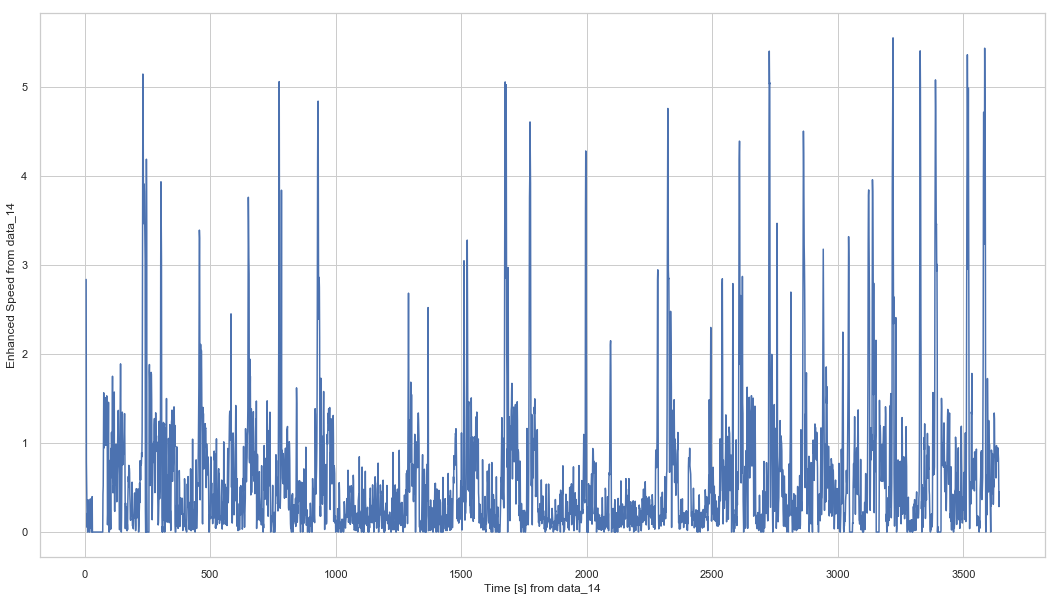

In [367]:
##Graph results: 
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

print("Plotting...")
#x = das_14_time
#y = speed_14_array

#avg_time_array.pop(-1)
#avg_speed_array.pop(-1)

x = avg_time_array
y = avg_speed_array

#x_ticks = np.arange([])
#y_ticks = np.arange([])

plt.figure(figsize=(18,10))

plt.plot(x,y)
plt.xlabel('Time [s] from data_14')
plt.ylabel('Enhanced Speed from data_14')
#frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels(x_ticks)
#frame1.axes.yaxis.set_ticklabels(y_ticks)

plt.show()

## Footage sync code written by Alina:

In [368]:
#Footage sync code written by Alina: (Miulti-Column)

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = 'Footage.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #----Complex "mode" below: --------
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

In [369]:
motion_df_simple = label_data('Footage3.txt')
motion_df_simple.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  TimeDelta_seconds Velocity  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789        0.0                  0      NaN   
        2018-11-09 19:16:04.053      252.5                  0      NaN   
        2018-11-09 19:16:04.284      501.5                  0      NaN   
        2018-11-09 19:16:04.548      753.5                  0      NaN   
        2018-11-09 19:16:04.812     1003.5                  1      NaN   
        2018-11-09 19:16:05.043     1253.5                  1      NaN   
        2018-11-09 19:16:05.307     1504.5                  1      NaN   
        2018-11-09 19:16:05.571     1755.5                  1      NaN   
        2018-11-09 19:16:05.802     2006.5                  2      NaN   
        2018-11-09 19:16:06.066     2258.5                  2      NaN   

                                 WALKING  FLOATING  SURFING  PADDLING  
ride_id UTC                                                            
15692   2018-11-09 19:16:03.789        0         0        0         0  
        2018-11-09 19:16:04.053        0         0        0         0  
        2018-11-09 19:16:04.284        0         0        0         0  
        2018-11-09 19:16:04.548        0         0        0         0  
        2018-11-09 19:16:04.812        0         0        0         0  
        2018-11-09 19:16:05.043        0         0        0         0  
        2018-11-09 19:16:05.307        0         0        0         0  
        2018-11-09 19:16:05.571        0         0        0         0  
        2018-11-09 19:16:05.802        0         0        0         0  
        2018-11-09 19:16:06.066        0         0        0         0

In [370]:
motion_df_complex = label_data('Footage3.txt', 'complex')
motion_df_complex.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  TimeDelta_seconds Velocity  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789        0.0                  0      NaN   
        2018-11-09 19:16:04.053      252.5                  0      NaN   
        2018-11-09 19:16:04.284      501.5                  0      NaN   
        2018-11-09 19:16:04.548      753.5                  0      NaN   
        2018-11-09 19:16:04.812     1003.5                  1      NaN   
        2018-11-09 19:16:05.043     1253.5                  1      NaN   
        2018-11-09 19:16:05.307     1504.5                  1      NaN   
        2018-11-09 19:16:05.571     1755.5                  1      NaN   
        2018-11-09 19:16:05.802     2006.5                  2      NaN   
        2018-11-09 19:16:06.066     2258.5                  2      NaN   

                                 PUSHING BOARD INTO WATER  \
ride_id UTC                                                 
15692   2018-11-09 19:16:03.789                         0   
        2018-11-09 19:16:04.053                         0   
        2018-11-09 19:16:04.284                         0   
        2018-11-09 19:16:04.548                         0   
        2018-11-09 19:16:04.812                         0   
        2018-11-09 19:16:05.043                         0   
        2018-11-09 19:16:05.307                         0   
        2018-11-09 19:16:05.571                         0   
        2018-11-09 19:16:05.802                         0   
        2018-11-09 19:16:06.066                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:1

In [371]:
## Drop all of the NaN values from columns (NaN due to velocity input feature): 
motion_df_simple = motion_df_simple[motion_df_simple.Velocity != "NaN"]
motion_df_complex = motion_df_complex[motion_df_complex.Velocity != "NaN"]

#motion_df_simple.head(10)
#motion_df_complex.head(10)

## Concatenate multiple footage files that we have so far to create a larger mass of data samples. 

In [372]:
df1_complex = label_data('Footage.txt', 'complex')
df2_complex = label_data('Footage2.txt', 'complex')
df3_complex = label_data('Footage3.txt', 'complex')
df4_complex = label_data('Footage4.txt', 'complex')

df_concatenated = pd.concat([df1_complex, df2_complex, df3_complex, df4_complex])

print("Shape of first dataframe:", df1_complex.shape)
print("Shape of all combined dataframes:", df_concatenated.shape)

print("Printing dataframe...")
#print(df1_complex.head(10))
print(df_concatenated.head(10))

/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Shape of first dataframe: (21645, 34)
Shape of all combined dataframes: (86580, 44)
Printing dataframe...
                                 DISCARD  DONE  DONE, OUT OF WATER  \
ride_id UTC                                                          
15692   2018-11-09 19:16:03.789      0.0   NaN                 NaN   
        2018-11-09 19:16:04.053      0.0   NaN                 NaN   
        2018-11-09 19:16:04.284      0.0   NaN                 NaN   
        2018-11-09 19:16:04.548      0.0   NaN                 NaN   
        2018-11-09 19:16:04.812      0.0   NaN                 NaN   
        2018-11-09 19:16:05.043      0.0   NaN                 NaN   
        2018-11-09 19:16:05.307      0.0   NaN                 NaN   
        2018-11-09 19:16:05.571      0.0   NaN                 NaN   
        2018-11-09 19:16:05.802      0.0   NaN                 NaN   
        2018-11-09 19:16:06.066      0.0   NaN                 NaN   

                                 END SURF SESH  FLIP 

In [373]:
#correct IMU data

#make a deep copy of motion_df_labelled
df_converted = motion_df_complex.copy(deep = 'true')

#for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= -0.019141  #forwards/backwards
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141   #upside down/right side up
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141   #sideways: negative = left, positive = right
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2        #roll
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2        #yaw
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2        #pitch (flipping forwards/backwards)

motion_df_complex.head(10)    


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:33.984  1.414773e+09     1.0   543.0    81.0   -20.0   
        2018-11-09 19:16:34.248  1.414773e+09   -58.0   511.0    64.0   -28.0   
        2018-11-09 19:16:34.479  1.414773e+09   -44.0   451.0    85.0    46.0   
        2018-11-09 19:16:34.743  1.414774e+09   -44.0   473.0   113.0   -61.0   
        2018-11-09 19:16:34.974  1.414774e+09   -17.0   511.0    76.0    64.0   
        2018-11-09 19:16:35.238  1.414774e+09  -191.0   406.0    74.0     2.0   
        2018-11-09 19:16:35.502  1.414774e+09     0.0   553.0    31.0   202.0   
        2018-11-09 19:16:35.733  1.414775e+09   -53.0   571.0   -61.0  -246.0   
        2018-11-09 19:16:35.997  1.414775e+09   -88.0   483.0    82.0   -20.0   
        2018-11-09 19:16:36.228  1.414775e+09   -23.0   416.0   138.0   174.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:33.984    -6.0    42.0   -38.0  -164.0   208.0   
        2018-11-09 19:16:34.248   -15.0   -27.0   -47.0  -163.0   205.0   
        2018-11-09 19:16:34.479     7.0   -46.0   -42.0  -162.0   196.0   
        2018-11-09 19:16:34.743    18.0   -38.0   -30.0  -156.0   196.0   
        2018-11-09 19:16:34.974    51.0    31.0   -35.0  -167.0   197.0   
        2018-11-09 19:16:35.238    15.0   138.0   -30.0  -160.0   210.0   
        2018-11-09 19:16:35.502   136.0   171.0   -54.0  -162.0   212.0   
        2018-11-09 19:16:35.733   203.0    64.0   -83.0  -159.0   215.0   
        2018-11-09 19:16:35.997   127.0   -77.0   -95.0  -173.0   199.0   
        2018-11-09 19:16:36.228    35.0   -99.0   -79.0  -155.0   213.0   

                                 TimeDelta  TimeDelta_seconds Velocity  \
ride_id UTC                                                              
15692   2018-11-09 19:16:33.984    30005.5                 30    2.837   
        2018-11-09 19:16:34.248    30257.5                 30    2.837   
        2018-11-09 19:16:34.479    30507.5                 30    2.837   
        2018-11-09 19:16:34.743    30758.5                 30    2.837   
        2018-11-09 19:16:34.974    31008.5                 31   0.7903   
        2018-11-09 19:16:35.238    31259.5                 31   0.7903   
        2018-11-09 19:16:35.502    31511.5                 31   0.7903   
        2018-11-09 19:16:35.733    31761.5                 31   0.7903   
        2018-11-09 19:16:35.997    32004.5                 32   0.5416   
        2018-11-09 19:16:36.228    32252.5                 32   0.5416   

                                 PUSHING BOARD INTO WATER  \
ride_id UTC                                                 
15692   2018-11-09 19:16:33.984                         1   
        2018-11-09 19:16:34.248                         1   
        2018-11-09 19:16:34.479                         1   
        2018-11-09 19:16:34.743                         1   
        2018-11-09 19:16:34.974                         1   
        2018-11-09 19:16:35.238                         1   
        2018-11-09 19:16:35.502                         1   
        2018-11-09 19:16:35.733                         1   
        2018-11-09 19:16:35.997                         1   
        2018-11-09 19:16:36.228                         1   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:33.984                                                  0    
        2018-11-09 19:16:34.248                                                  0    
        2018-11-09 19:16:34.479                                                  0    
        2018-11-09 19:16:34.743                                                  0    
        2018-11-09 19:1

In [374]:
df_converted.head(10)

Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:33.984  1.414773e+09 -0.019141  10.393563  1.550421   
        2018-11-09 19:16:34.248  1.414773e+09  1.110178   9.781051  1.225024   
        2018-11-09 19:16:34.479  1.414773e+09  0.842204   8.632591  1.626985   
        2018-11-09 19:16:34.743  1.414774e+09  0.842204   9.053693  2.162933   
        2018-11-09 19:16:34.974  1.414774e+09  0.325397   9.781051  1.454716   
        2018-11-09 19:16:35.238  1.414774e+09  3.655931   7.771246  1.416434   
        2018-11-09 19:16:35.502  1.414774e+09 -0.000000  10.584973  0.593371   
        2018-11-09 19:16:35.733  1.414775e+09  1.014473  10.929511 -1.167601   
        2018-11-09 19:16:35.997  1.414775e+09  1.684408   9.245103  1.569562   
        2018-11-09 19:16:36.228  1.414775e+09  0.440243   7.962656  2.641458   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:33.984  -2.439024  -0.731707   5.121951   -38.0   
        2018-11-09 19:16:34.248  -3.414634  -1.829268  -3.292683   -47.0   
        2018-11-09 19:16:34.479   5.609756   0.853659  -5.609756   -42.0   
        2018-11-09 19:16:34.743  -7.439024   2.195122  -4.634146   -30.0   
        2018-11-09 19:16:34.974   7.804878   6.219512   3.780488   -35.0   
        2018-11-09 19:16:35.238   0.243902   1.829268  16.829268   -30.0   
        2018-11-09 19:16:35.502  24.634146  16.585366  20.853659   -54.0   
        2018-11-09 19:16:35.733 -30.000000  24.756098   7.804878   -83.0   
        2018-11-09 19:16:35.997  -2.439024  15.487805  -9.390244   -95.0   
        2018-11-09 19:16:36.228  21.219512   4.268293 -12.073171   -79.0   

                                 IMU M2  IMU M3  TimeDelta  TimeDelta_seconds  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:33.984  -164.0   208.0    30005.5                 30   
        2018-11-09 19:16:34.248  -163.0   205.0    30257.5                 30   
        2018-11-09 19:16:34.479  -162.0   196.0    30507.5                 30   
        2018-11-09 19:16:34.743  -156.0   196.0    30758.5                 30   
        2018-11-09 19:16:34.974  -167.0   197.0    31008.5                 31   
        2018-11-09 19:16:35.238  -160.0   210.0    31259.5                 31   
        2018-11-09 19:16:35.502  -162.0   212.0    31511.5                 31   
        2018-11-09 19:16:35.733  -159.0   215.0    31761.5                 31   
        2018-11-09 19:16:35.997  -173.0   199.0    32004.5                 32   
        2018-11-09 19:16:36.228  -155.0   213.0    32252.5                 32   

                                Velocity  PUSHING BOARD INTO WATER  \
ride_id UTC                                                          
15692   2018-11-09 19:16:33.984    2.837                         1   
        2018-11-09 19:16:34.248    2.837                         1   
        2018-11-09 19:16:34.479    2.837                         1   
        2018-11-09 19:16:34.743    2.837                         1   
        2018-11-09 19:16:34.974   0.7903                         1   
        2018-11-09 19:16:35.238   0.7903                         1   
        2018-11-09 19:16:35.502   0.7903                         1   
        2018-11-09 19:16:35.733   0.7903                         1   
        2018-11-09 19:16:35.997   0.5416                         1   
        2018-11-09 19:16:36.228   0.5416                         1   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:33.984                                                  0    
        2018-11-09 19:16:34.248                                                  0    
     

In [375]:
list(df_converted)

['Time',
 'IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'TimeDelta',
 'TimeDelta_seconds',
 'Velocity',
 'PUSHING BOARD INTO WATER',
 'SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)',
 'FLIP BOARD RIGHT SIDE UP',
 'WALKING IN WATER',
 'PUSH-OFF',
 'PADDLING INTO WAVES',
 'SIT-UP',
 'FLOATING',
 "TURNING TO SURFER'S LEFT",
 'LAY-DOWN',
 'PADDLING FOR A WAVE',
 'POP-UP',
 'SURFING',
 'STEP-OFF',
 "TURNING TO SURFER'S RIGHT",
 'SIT-BACK',
 'OFF-BOARD',
 'PADDLING',
 'WIPE-OUT',
 'PULL-BACK LEASH',
 'PADDLING FOR POSITION',
 'NEW',
 'DONE, OUT OF WATER',
 'WALKING OUT OF WATER']

In [376]:
## Drop data columns that we don't care about predicting/visualizing: 
df_converted = df_converted.drop(columns=["FLIP BOARD RIGHT SIDE UP", "NEW", "DONE, OUT OF WATER"])
#df_converted = df_converted.drop(columns!=["SURFING, FLOATING, PADDLING INTO WAVES, PADDLING FOR A WAVE, PADDLING FOR POSITION, PADDLING"])

## Plot IMU Signals with Labels:

In [377]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        #Only consider columns after Velocity
        dfPlot = pd.DataFrame(columns = ['TIME'] + list(dataf)[list(dataf).index('Velocity') + 1:], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]
                    #dfPlot.iloc[row, dfPlot.columns.get]
        
        #Set up colormap so that we don't see a repeat in color when graphing
        #plt.gca().set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1,dfPlot.shape[1])))
        plt.gca().set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,dfPlot.shape[1])))
        for col in range (1, dfPlot.shape[1]):
            plt.plot(dfPlot['TIME'], dfPlot[list(dfPlot)[col]])
        
        plt.gca().legend(loc = 'lower left')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        #file_name = column
        #pdf_string = '.jpg'
        #file_name += pdf_string
        
        #plt.savefig(file_name)
        plt.show()
        
        return 

Creating Plots...


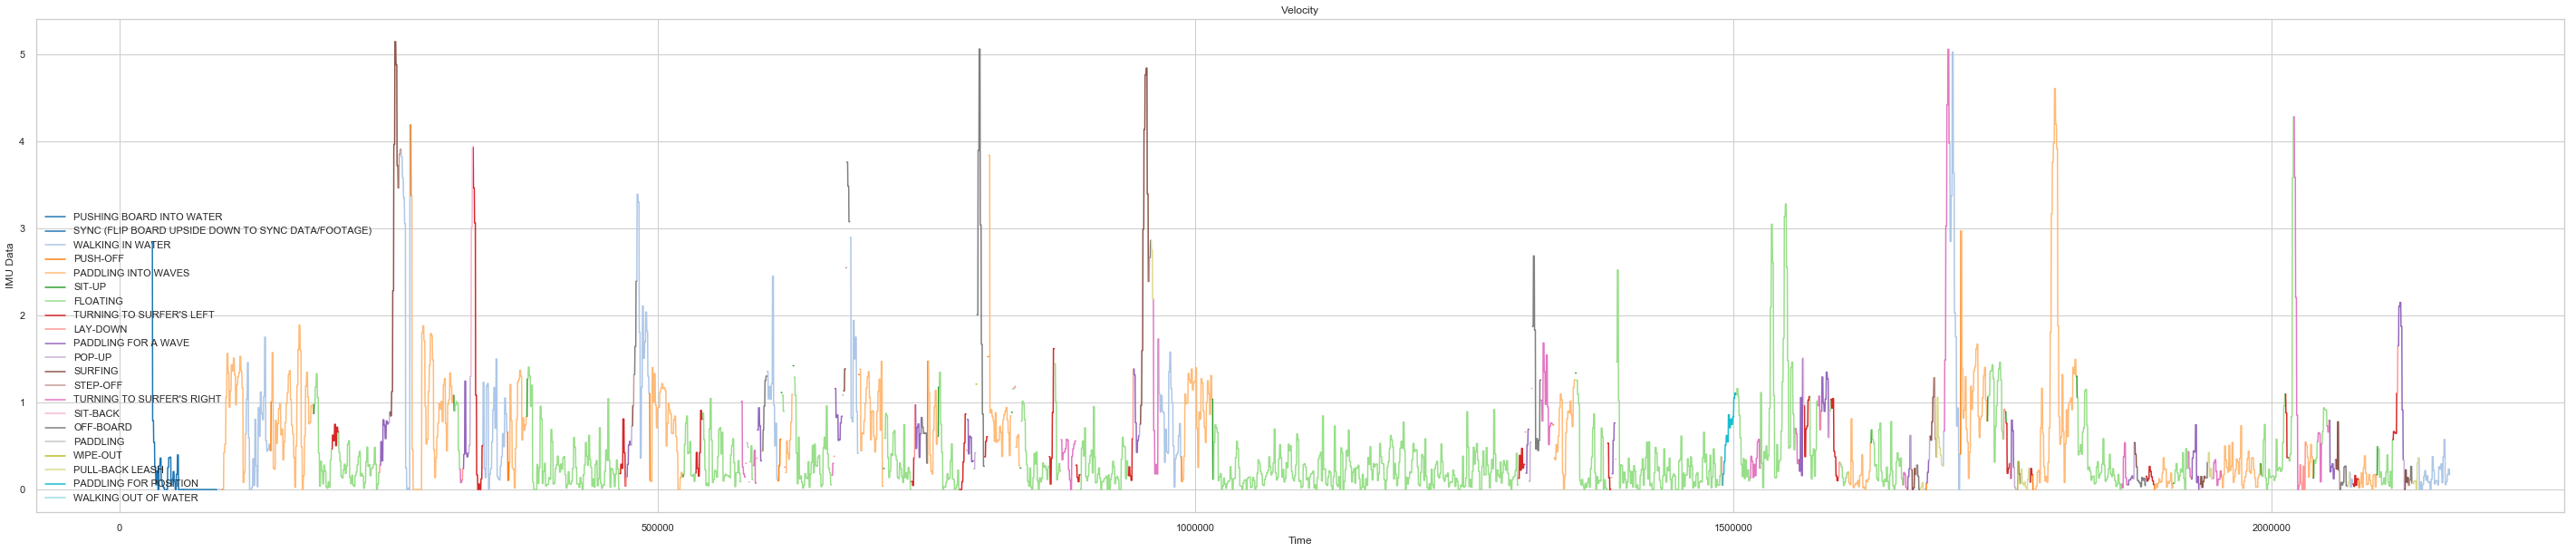

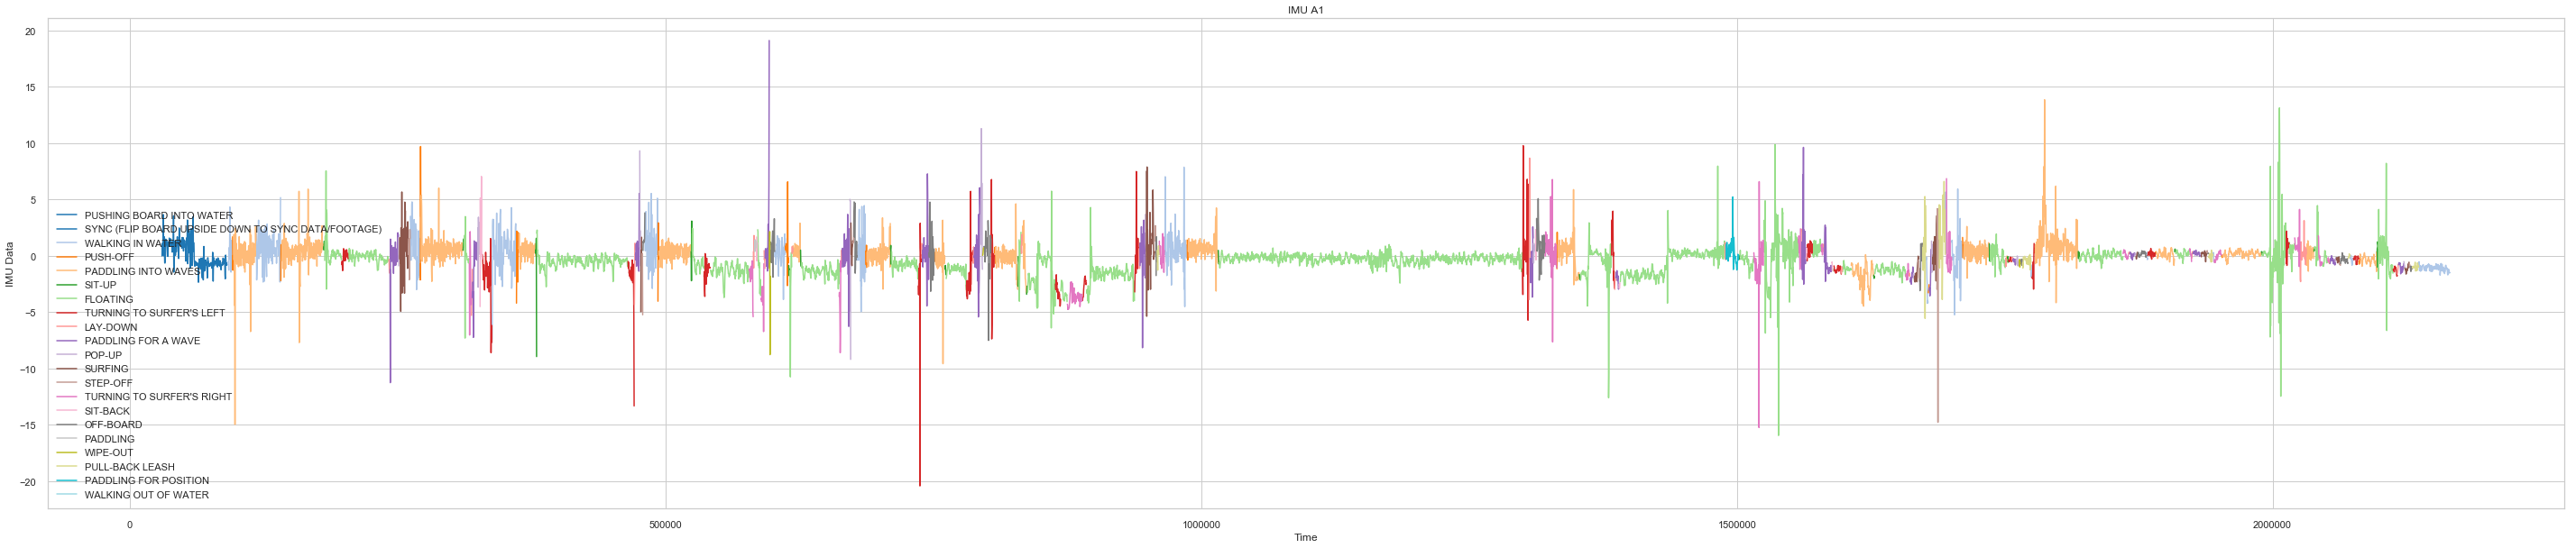

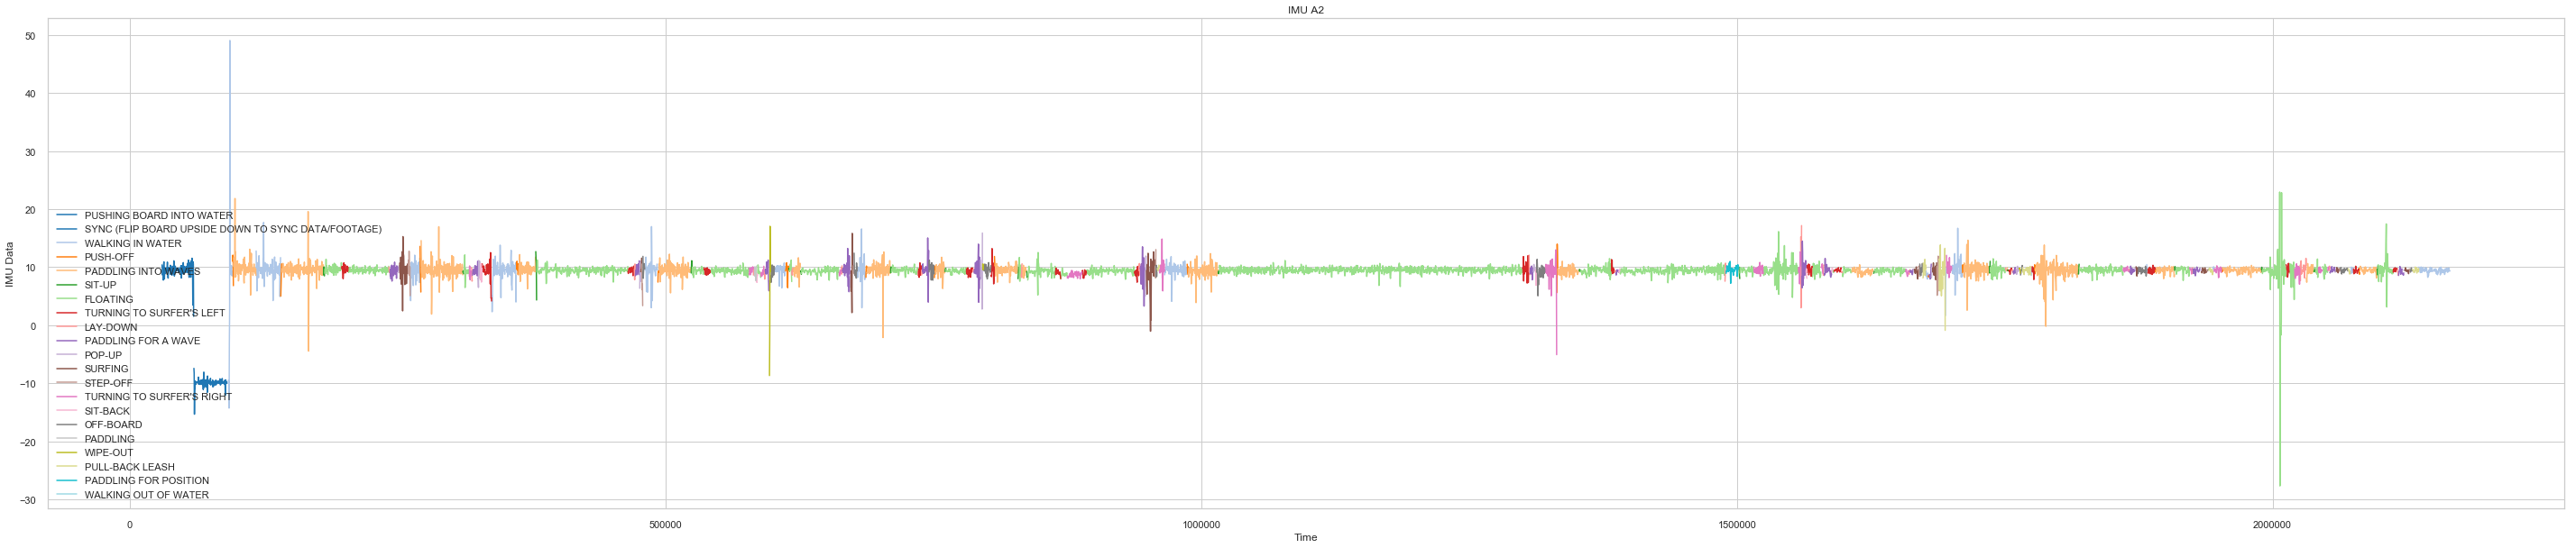

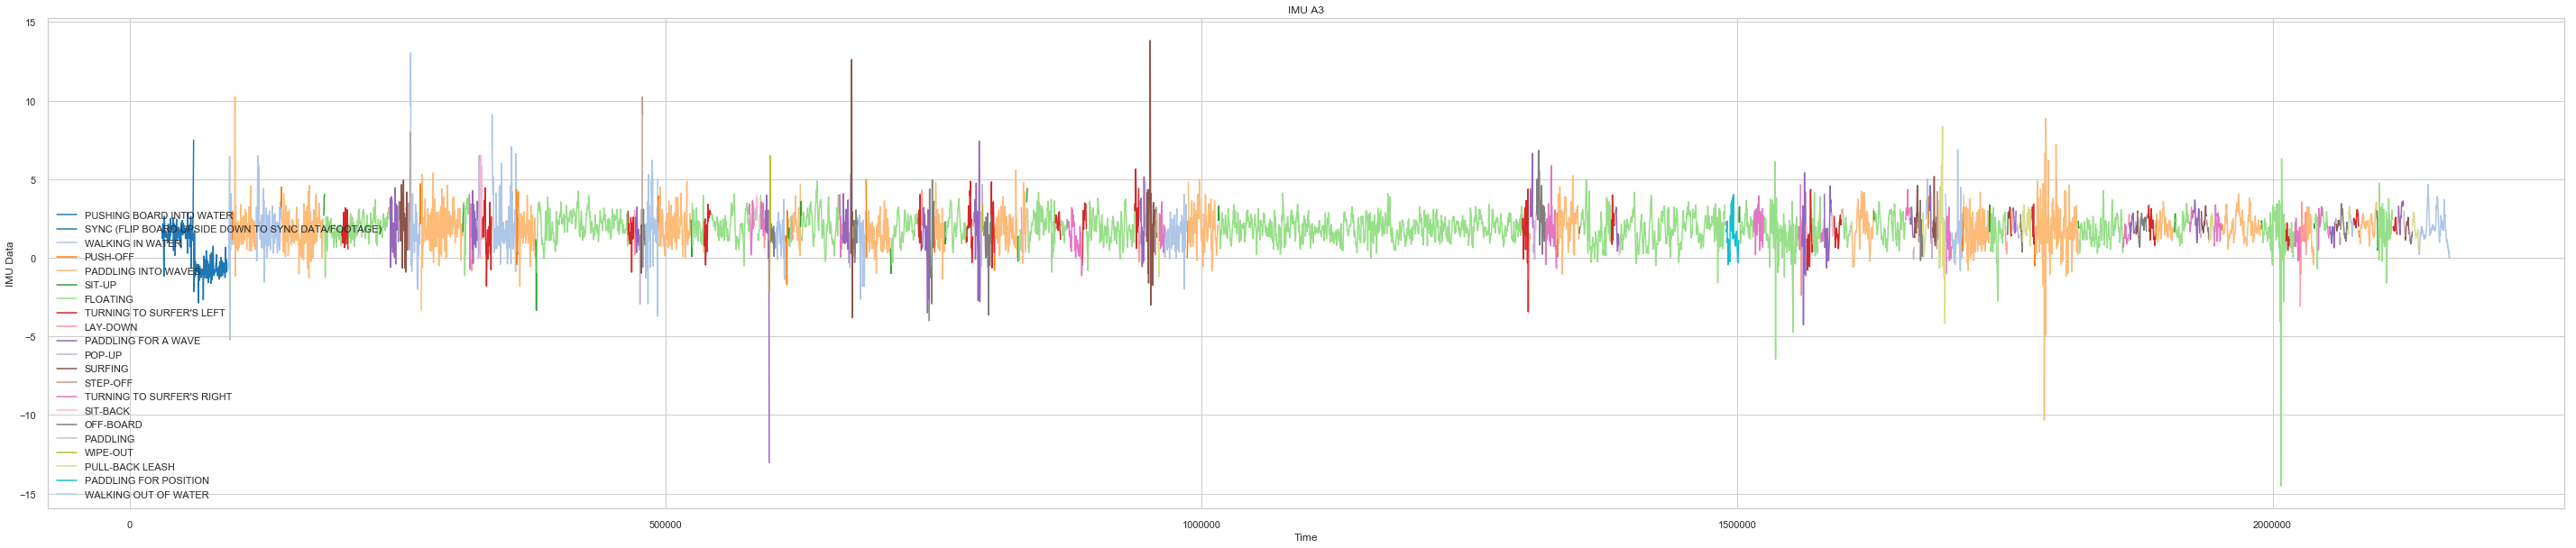

Done


In [378]:
#For plotting, just comment out the "concatenation" lines. 

#Need to clear kernel and then only run all above so that it plots on axes directly below, rather than on another plot
print("Creating Plots...")
createPlot(df_converted,'Velocity')
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')
#createPlot(df_converted,'IMU G1')
#createPlot(df_converted,'IMU G2')
#createPlot(df_converted,'IMU G3')
#createPlot(df_converted,'IMU M1')
#createPlot(df_converted,'IMU M2')
#createPlot(df_converted,'IMU M3')

print("Done")


## Butterworth Bandpass Filter

Plotting:


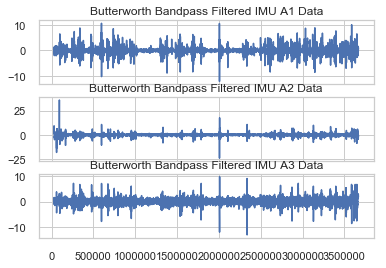

The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...


In [379]:
## Apply a Filter to the signals to reduce noise:
## Butter Filters for Bandpass:
%matplotlib inline
from scipy import signal
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y




# Define the sample rate and the Low and High Cutoff frequencies
#fs = 30
fs = 5
lowcut = 0.0333
highcut = 1.5


#Get each IMU column from the dataframe: 
#array = df_converted.values

time_array = df_converted['TimeDelta'].values
imua1_array = df_converted['IMU A1'].values
imua2_array = df_converted['IMU A2'].values
imua3_array = df_converted['IMU A3'].values

imug1_array = df_converted['IMU G1'].values
imug2_array = df_converted['IMU G2'].values
imug3_array = df_converted['IMU G3'].values

imum1_array = df_converted['IMU M1'].values
imum2_array = df_converted['IMU M2'].values
imum3_array = df_converted['IMU M3'].values


##Graphing the bandpass filters:
#A bandpass filter is both a highpass and a lowpass filter combined.
butter_lfilter_a1 = butter_bandpass_lfilter(imua1_array, lowcut, highcut, fs, order=5)
butter_lfilter_a2 = butter_bandpass_lfilter(imua2_array, lowcut, highcut, fs, order=5)
butter_lfilter_a3 = butter_bandpass_lfilter(imua3_array, lowcut, highcut, fs, order=5)



#butter_filtfilt = butter_bandpass_filtfilt(dacc_array1, lowcut, highcut, fs, order=5)



#Can change num_elems to 1000 for example if you only want to graph the first 1000 elems:
num_elems = len(time_array)

print("Plotting:")
plt.figure(1)
plt.subplot(311)
plt.plot(time_array[:num_elems], butter_lfilter_a1[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A1 Data")

plt.subplot(312)
plt.plot(time_array[:num_elems], butter_lfilter_a2[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A2 Data")

plt.subplot(313)
plt.plot(time_array[:num_elems], butter_lfilter_a3[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A3 Data")

#Save as file
file_name = "butter_worth_graphs"
pdf_string = '.jpg'
file_name += pdf_string
plt.savefig(file_name)

#Show in line
plt.show()

print("The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...")

### Filtering data with a butterworth filter, then plotting in 2D: 

Plotting...


<IPython.core.display.Javascript object>


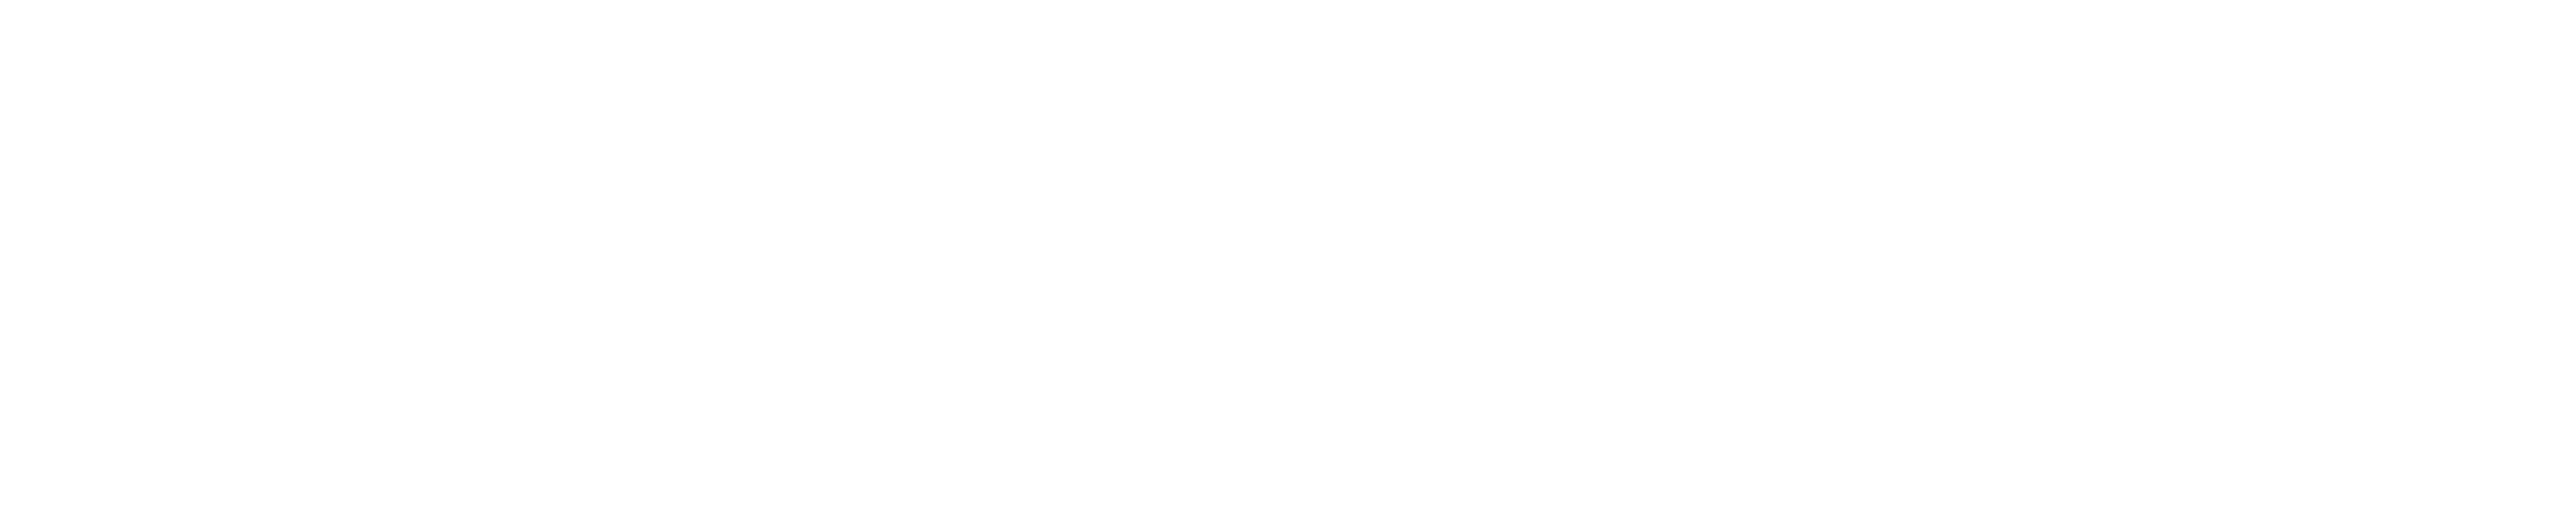

Done


<IPython.core.display.Javascript object>


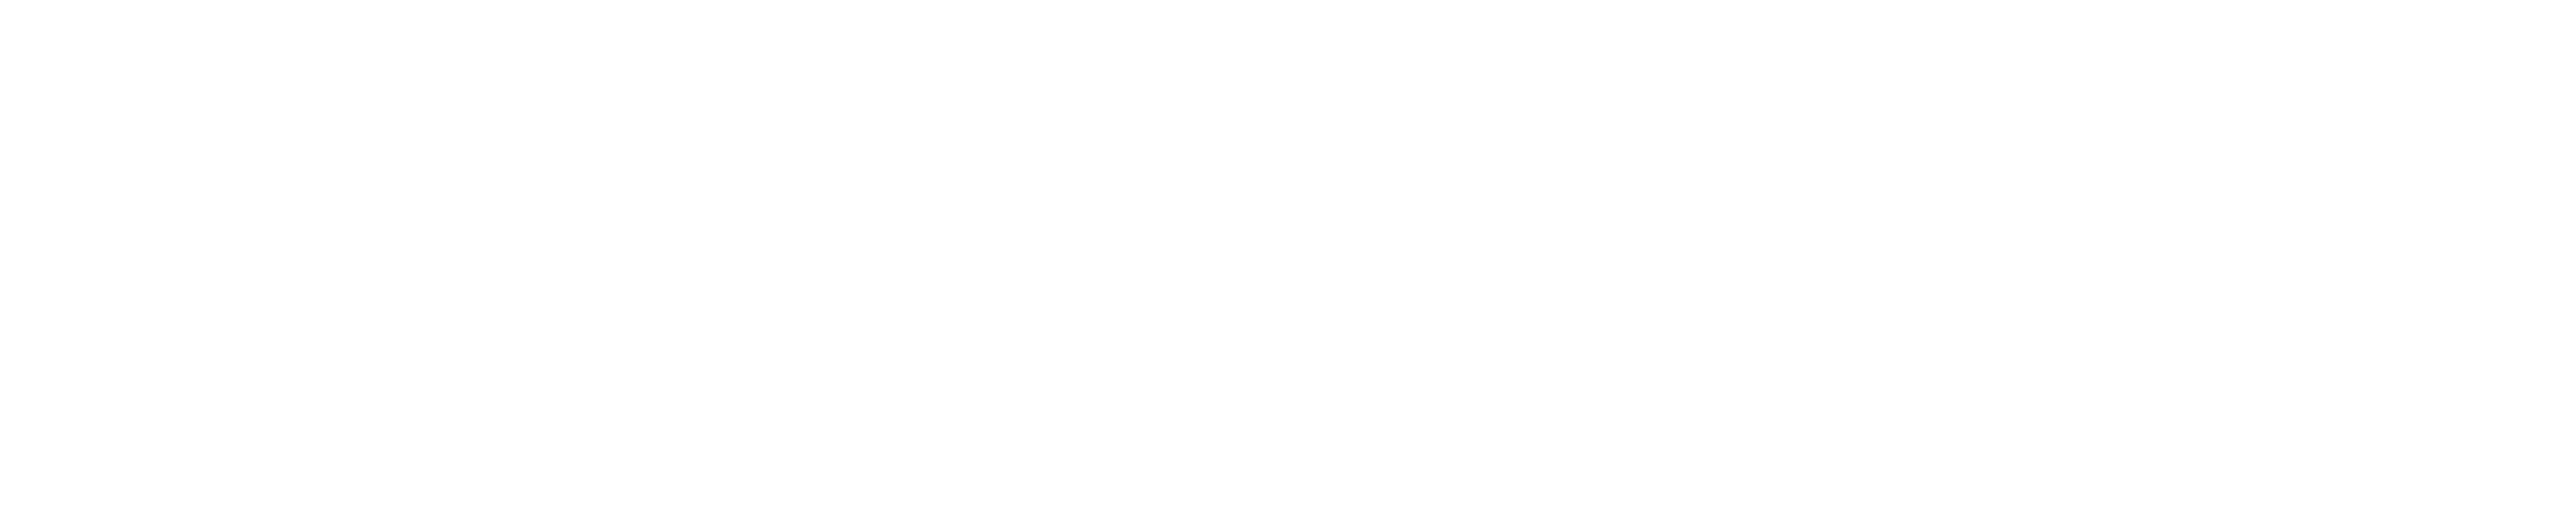

In [380]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = imua1_array
y = imug1_array
area = np.pi*3

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('IMU A1')
plt.ylabel('IMU G3')
plt.show()
print("Done")

## Update dataframe with the filtered values, then do another labelled plot of all IMU values: 

## Binary Logistic Regression Model on Raw data values: 

In [381]:
## Make sure that the df_converted that gets copied does not get changed by the filtering methods being tested.
dataset = df_converted.copy()

print(dataset.head(100))

                                         Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:33.984  1.414773e+09 -0.019141  10.393563  1.550421   
        2018-11-09 19:16:34.248  1.414773e+09  1.110178   9.781051  1.225024   
        2018-11-09 19:16:34.479  1.414773e+09  0.842204   8.632591  1.626985   
        2018-11-09 19:16:34.743  1.414774e+09  0.842204   9.053693  2.162933   
        2018-11-09 19:16:34.974  1.414774e+09  0.325397   9.781051  1.454716   
        2018-11-09 19:16:35.238  1.414774e+09  3.655931   7.771246  1.416434   
        2018-11-09 19:16:35.502  1.414774e+09 -0.000000  10.584973  0.593371   
        2018-11-09 19:16:35.733  1.414775e+09  1.014473  10.929511 -1.167601   
        2018-11-09 19:16:35.997  1.414775e+09  1.684408   9.245103  1.569562   
        2018-11-09 19:16:36.228  1.414775e+09  0.440243   7.962656  2.641458   
        2018-11-09 19:16:36.492  1.41477

In [382]:
print(dataset.columns)

Index(['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3',
       'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'TimeDelta_seconds',
       'Velocity', 'PUSHING BOARD INTO WATER',
       'SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)',
       'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP',
       'FLOATING', 'TURNING TO SURFER'S LEFT', 'LAY-DOWN',
       'PADDLING FOR A WAVE', 'POP-UP', 'SURFING', 'STEP-OFF',
       'TURNING TO SURFER'S RIGHT', 'SIT-BACK', 'OFF-BOARD', 'PADDLING',
       'WIPE-OUT', 'PULL-BACK LEASH', 'PADDLING FOR POSITION',
       'WALKING OUT OF WATER'],
      dtype='object')


In [383]:
#Link which explains below: 
#https://stackoverflow.com/questions/37512079/python-pandas-why-does-df-iloc-1-values-for-my-training-data-select-till
X = dataset.iloc[:, :11].values  #selects everything until the last column listed (in this case, the 0-10 columns get taken)
#TURNING TO SURFER\'S RIGHT
y = dataset.loc[:,'SURFING'].values   #selects the column specified (ex: 'FLOATING')
print("X.shape:", X.shape)
print("y.shape:", y.shape)


#What is the column heading of the y column given? 
print(dataset.iloc[0][-1])

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("first few y_train values:", y_train[0:10])
print("first few y_test values:", y_test[0:10])

#The y-axis is currently set to the 19th frame ("FLOATING").

X_train_res = X_train
y_train_res = y_train

X.shape: (15560, 11)
y.shape: (15560,)
0
x_train shape: (14004, 11)
y_train shape: (14004,)
x_test shape: (1556, 11)
y_test shape: (1556,)
first few y_train values: [0 0 0 0 0 0 0 0 0 0]
first few y_test values: [0 0 0 0 0 0 0 0 0 0]


In [384]:
#May need to use SMOTE technique to balance the data more equally (so majority class i.e. 0 doesn't dominate).
#SMOTE explanation: http://rikunert.com/SMOTE_explained
#Example code: https://beckernick.github.io/oversampling-modeling/

from imblearn.over_sampling import SMOTE, ADASYN


sm = SMOTE(random_state=12, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)  #oversample on only the training data, after splitting the data initially into training and testing sets


#Use SMOTE to balance the training sets: 
#X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

#OR use ADASYN to balance the training sets: 
#X_train_res, y_train_res = ADASYN().fit_resample(X_train, y_train)

In [385]:
# Fit into Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs')
classifier.fit(X=X_train_res, y=y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [386]:
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

# Predicting the Test set results
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

#print("Printing every y in y_test:")
#for y in y_test:
#    print(y)
#print(y_test)

print(y_pred[0:500]) #just checking to make sure that it's actually guessing (not just always 0)

[[896 644]
 [ 12   4]]
[0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1
 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1
 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1
 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0
 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0
 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0
 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1
 0

<IPython.core.display.Javascript object>


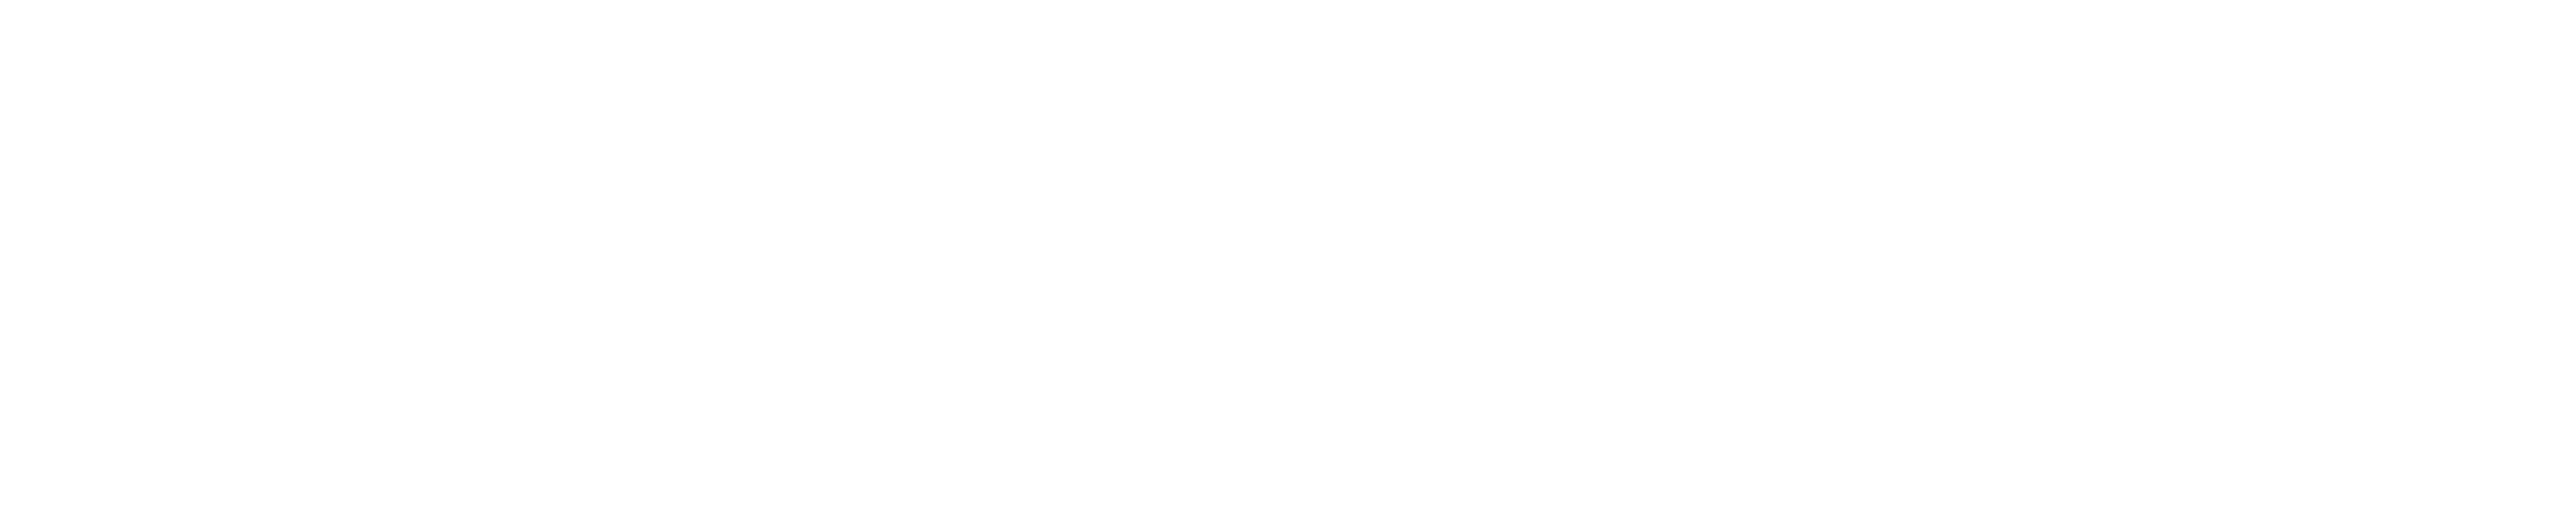

0.5784061696658098

<IPython.core.display.Javascript object>


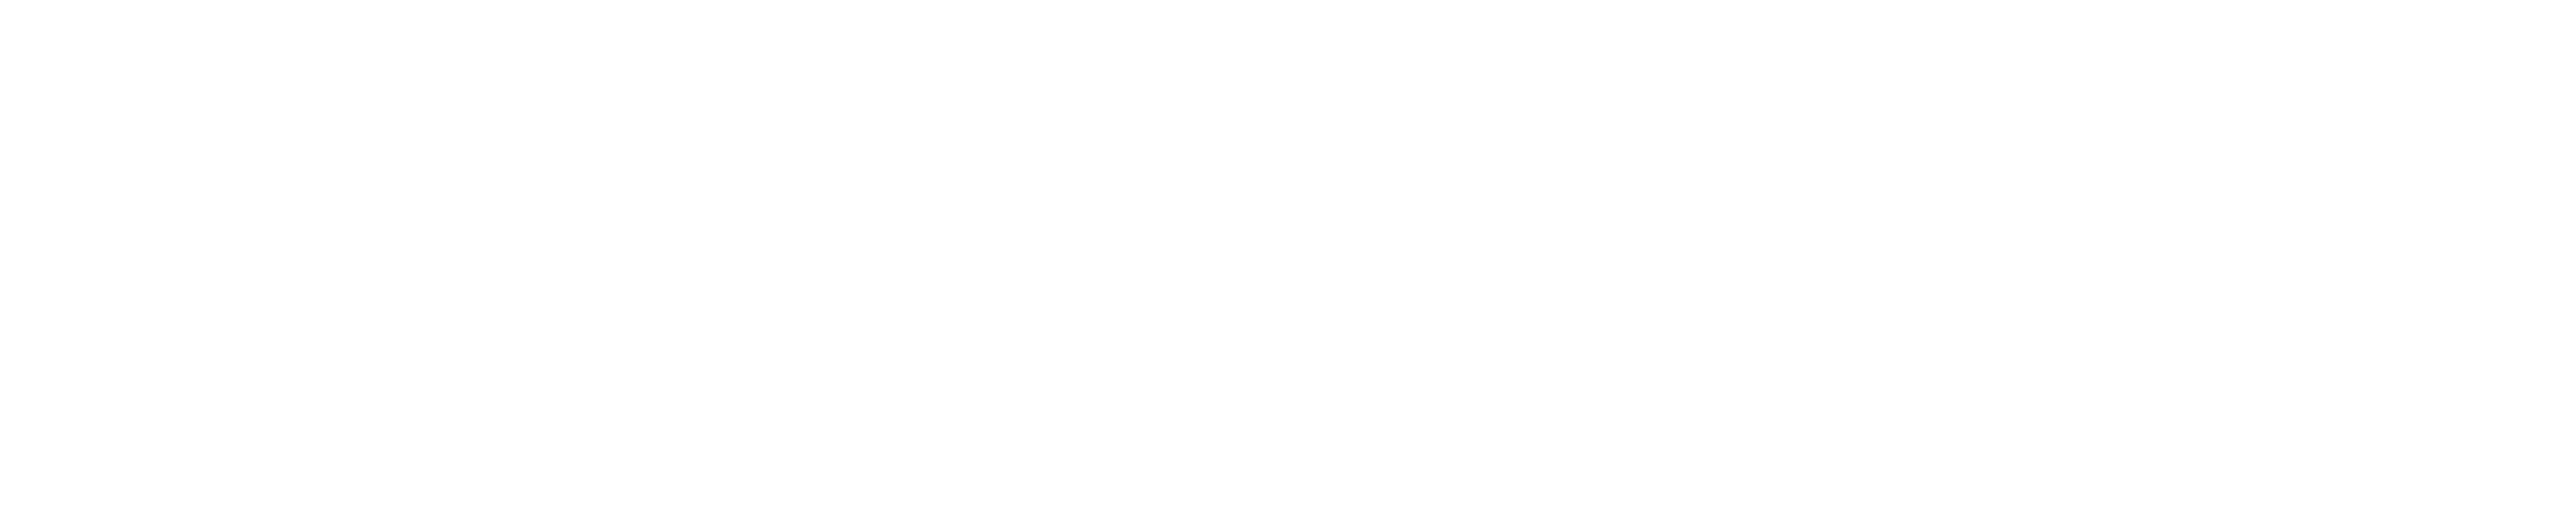

In [387]:
#Make a prettier looking confusion matrix using yellowbrick visualizers: 

cm = ConfusionMatrix(classifier, classes=[0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_res, y_train_res)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
#cm.poof()


In [388]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = classifier, X = X_train_res, y = y_train_res, cv = 10)
print(score)

[0.51770231 0.51011561 0.49313584 0.4949422  0.49783237 0.4974711
 0.50036127 0.50216763 0.48553868 0.50289226]


In [389]:
avg = 0.0
for s in score: 
    avg += s
avg = avg/10.0
print(avg)

0.5002159270915618


## Training Multiple Binary Logistic Regression Models

In [390]:
#Create one for surfing, paddling, floating, etc. all trained on same training data

#For each point in the "test" category, determine the probability that it is floating/paddling/surfing

#Choose the model that gives the highest probability 



## Setting up dataframe for Single Multinomial Logistic Regression Model
### Footage sync code: (Single-Column, Multi-Class)

In [391]:
#Copy the converted dataset, keep the features, and create only one column that contains labels. 

print("Creating multiclass dataframe...")

#Can also add "UTC Time" and "Time Delta" columns if needed later. 
multiclass_df = df_converted[['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', "Velocity"]].copy()
parse_df = df_converted.copy()

print(multiclass_df.head(10))
      
    
#Parse the columns of the original dataframe to extract labels into a single column for the new multiclass df. 
def parse_func(x):
    l=[]
    val = 1
    for col in parse_df:
        if x[col] == val:
            l.append(col)

    return pd.Series(l)

parse_df = parse_df.apply(parse_func, axis=1)
print(parse_df.head(100))


#Drop the 2nd column of parse_df (which has all NaN values)
cols = [1]
parse_df.drop(parse_df.columns[cols],axis=1,inplace=True)
parse_df.columns=['complex_label']
#print(parse_df.head(100))


#Concatenate the parse column with the multiclass dataframe. 
multiclass_df = pd.concat([multiclass_df, parse_df], axis=1, sort=False)
#print(multiclass_df.head(100))

#Drop the NaN rows from the beginning/end of the df.
print("Shape before dropping NA:", multiclass_df.shape)
multiclass_df = multiclass_df.dropna()
print("Shape after dropping NA:", multiclass_df.shape)
print(multiclass_df.head(10))


complex_multiclass_df = multiclass_df.copy()
print("\n Done creating complex multiclass df.")


Creating multiclass dataframe...
                                   IMU A1     IMU A2    IMU A3     IMU G1  \
ride_id UTC                                                                 
15692   2018-11-09 19:16:33.984 -0.019141  10.393563  1.550421  -2.439024   
        2018-11-09 19:16:34.248  1.110178   9.781051  1.225024  -3.414634   
        2018-11-09 19:16:34.479  0.842204   8.632591  1.626985   5.609756   
        2018-11-09 19:16:34.743  0.842204   9.053693  2.162933  -7.439024   
        2018-11-09 19:16:34.974  0.325397   9.781051  1.454716   7.804878   
        2018-11-09 19:16:35.238  3.655931   7.771246  1.416434   0.243902   
        2018-11-09 19:16:35.502 -0.000000  10.584973  0.593371  24.634146   
        2018-11-09 19:16:35.733  1.014473  10.929511 -1.167601 -30.000000   
        2018-11-09 19:16:35.997  1.684408   9.245103  1.569562  -2.439024   
        2018-11-09 19:16:36.228  0.440243   7.962656  2.641458  21.219512   

                                    IMU G2

### Create Simplified Multiclass Labels

In [392]:
#Create simple multiclass df: (Surfing, Floating, Paddling, Misc.)

simple_multiclass_df = multiclass_df.copy()

simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('SURFING|PADDLING|FLOATING|POP-UP')==False, 'complex_label'] = 'MISC'
simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('PADDLING'), 'complex_label'] = 'PADDLING'

##simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('POP-UP'), 'complex_label'] = 'SURFING'
##simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('TURNING'), 'complex_label'] = 'FLOATING'


column_names = list(simple_multiclass_df)
column_names = column_names[:-1]
column_names.append("simple_label")

print(column_names)
simple_multiclass_df.columns=column_names

print(simple_multiclass_df.head(5))

simple_misc_multiclass_df = simple_multiclass_df.copy()

#Check to see that labels exist: 
simple_multiclass_df = simple_multiclass_df[simple_multiclass_df['simple_label'].str.match('FLOATING|PADDLING|SURFING')]

print(simple_multiclass_df.head(5))


['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'Velocity', 'simple_label']
                                   IMU A1     IMU A2    IMU A3    IMU G1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:33.984 -0.019141  10.393563  1.550421 -2.439024   
        2018-11-09 19:16:34.248  1.110178   9.781051  1.225024 -3.414634   
        2018-11-09 19:16:34.479  0.842204   8.632591  1.626985  5.609756   
        2018-11-09 19:16:34.743  0.842204   9.053693  2.162933 -7.439024   
        2018-11-09 19:16:34.974  0.325397   9.781051  1.454716  7.804878   

                                   IMU G2    IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:33.984 -0.731707  5.121951   -38.0  -164.0   208.0   
        2018-11-09 19:16:34.248 -1.829268 -3.292683   -47.0  -163.0   205.0   
        2018-11-09 19:16:34.479 

## Visualizing raw multinomial data: 

### Need to run the %matplotlib notebook cells 2-3x in a row to get proper display:

['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
6688


<IPython.core.display.Javascript object>


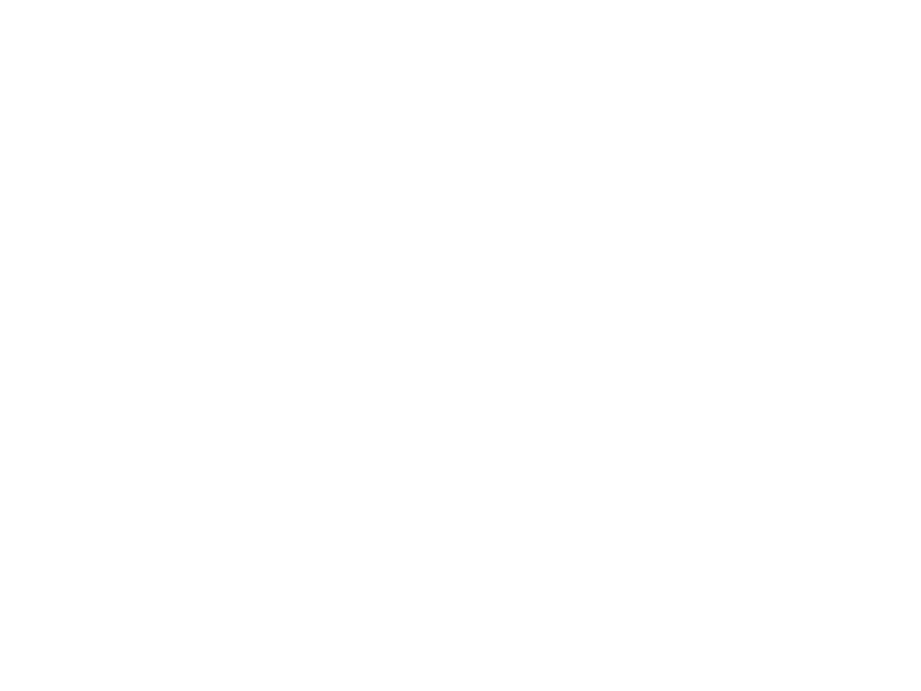

In [347]:
##Visualizing the data in 3d. 

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

data = simple_multiclass_df.copy()

data_y = data.loc[:,'simple_label'].values
#y = y.tolist()
print(data_y)

n = len(data_y)
print(n)

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")
        
#print(colors)



td_plot = plt.figure(figsize=[6.4, 4.8]).gca(projection='3d')
td_plot.scatter(data['IMU A1'], data['IMU A2'], data['IMU A3'], c=colors)
#td_plot.scatter(data['IMU G1'], data['IMU G2'], data['IMU G3'])
td_plot.set_xlabel('IMU A1')
td_plot.set_ylabel('IMU A2')
td_plot.set_zlabel('IMU A3')
plt.show()

Plotting...


<IPython.core.display.Javascript object>


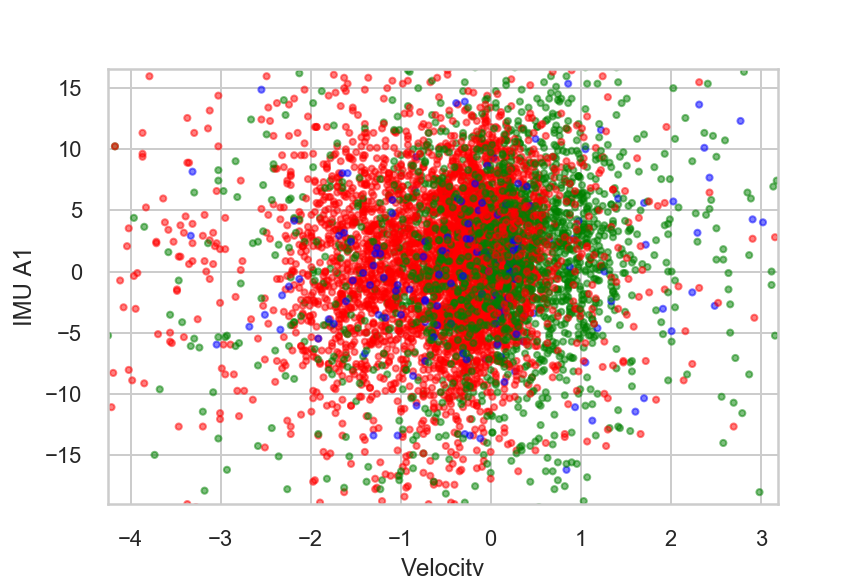

Done


In [348]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = data['IMU A1']
y = data['IMU G3']
area = np.pi*3

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('Velocity')
plt.ylabel('IMU A1')
#plt.ylabel('IMU G3')
plt.show()
print("Done")


['MISC' 'MISC' 'MISC' ... 'MISC' 'MISC' 'MISC']
9327


<IPython.core.display.Javascript object>


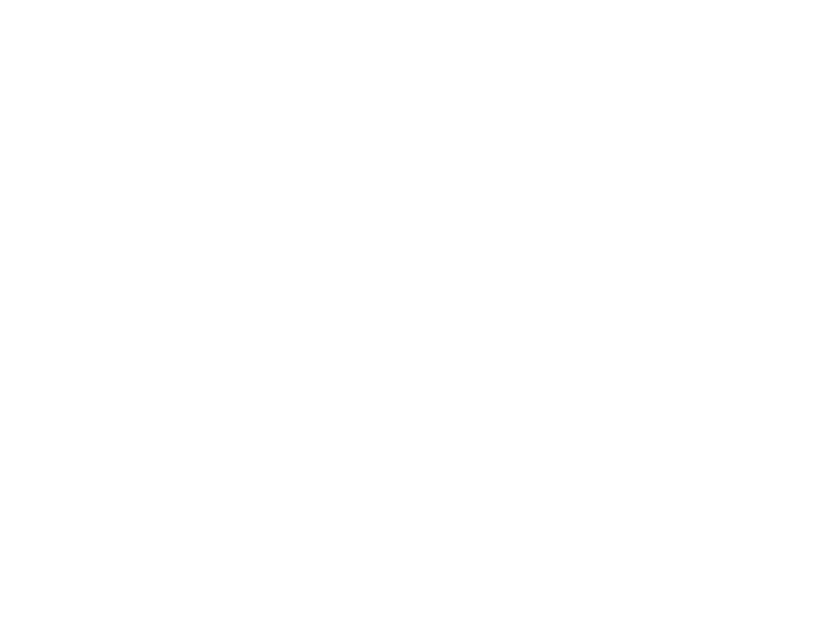

In [268]:
#Same visualization as above but including MISC values. 
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

data = simple_misc_multiclass_df.copy()

data_y = data.loc[:,'simple_label'].values
#y = y.tolist()
print(data_y)

n = len(data_y)
print(n)

colors = []
for i in range(0,n):
    if data_y[i] == 'MISC': 
        colors.append("red")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("yellow")
        
#print(colors)



td_plot = plt.figure(figsize=[6.4, 4.8]).gca(projection='3d')
td_plot.scatter(data['IMU A1'], data['IMU A2'], data['IMU A3'], c=colors)
#td_plot.scatter(data['IMU G1'], data['IMU G2'], data['IMU G3'])
td_plot.set_xlabel('IMU A1')
td_plot.set_ylabel('IMU A2')
td_plot.set_zlabel('IMU A3')
plt.show()

Plotting...


<IPython.core.display.Javascript object>


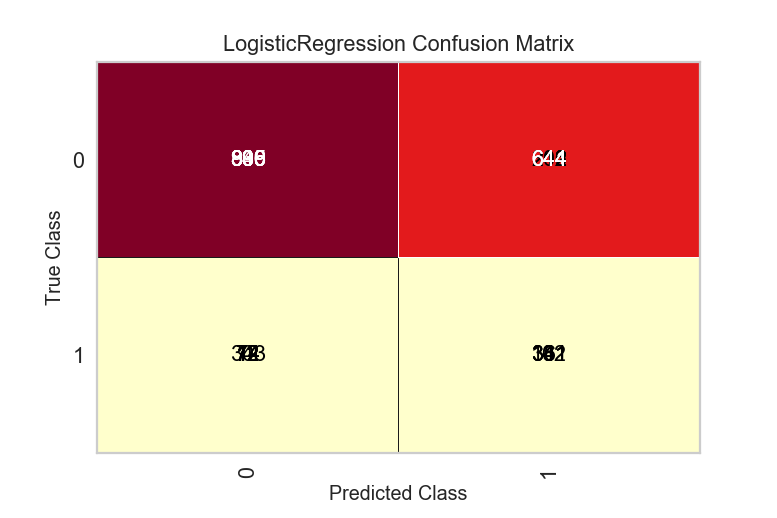

Done


In [270]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = data['IMU A1']
y = data['IMU G3']
area = np.pi*3

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    #if data_y[i] == 'PADDLING':
         #colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")
    #if data_y[i] == 'MISC':
        #colors.append("yellow")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('Velocity')
plt.ylabel('IMU A1')
#plt.ylabel('IMU G3')
plt.show()
print("Done")


## Pre-Processing Steps for Multinomial Logistic Regression

In [393]:
#If we don't want to include MISC values: 
simple_multi_dataset = simple_multiclass_df.copy()
print(simple_multi_dataset.columns)

#If we do want to include MISC values: 
#simple_multi_dataset = simple_misc_multiclass_df.copy()

Index(['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1',
       'IMU M2', 'IMU M3', 'Velocity', 'simple_label'],
      dtype='object')


In [394]:
#Need to scale all feature values



In [400]:
#Need to split into testing and training sets

X = simple_multi_dataset.iloc[:, :-1].values  #selects everything until the last column listed
y = simple_multi_dataset.iloc[:, -1].values   #selects the last column 

#X = simple_misc_multiclass_df.iloc[:, :-1].values  #selects everything until the last column listed
#y = simple_misc_multiclass_df.iloc[:, -1].values   #selects the last column 


print("X.shape:", X.shape)
print("y.shape:", y.shape)

print("y:", y)

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y_val in y: 
    if y_val == "FLOATING":
        count_y_float+=1
    if y_val == "PADDLING":
        count_y_paddle+=1
    if y_val == "SURFING":
        count_y_surf+=1

print("Num floating: ", count_y_float)
print("Num paddling: ", count_y_paddle)
print("Num surfing: ", count_y_surf)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

#print("first few y_train values:", y_train[0:10])
#print("first few y_test values:", y_test[0:10])



X.shape: (6688, 10)
y.shape: (6688,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
Num floating:  4312
Num paddling:  2196
Num surfing:  180
x_train shape: (6019, 10)
y_train shape: (6019,)
x_test shape: (669, 10)
y_test shape: (669,)


### Setting up the dataset: 

<IPython.core.display.Javascript object>


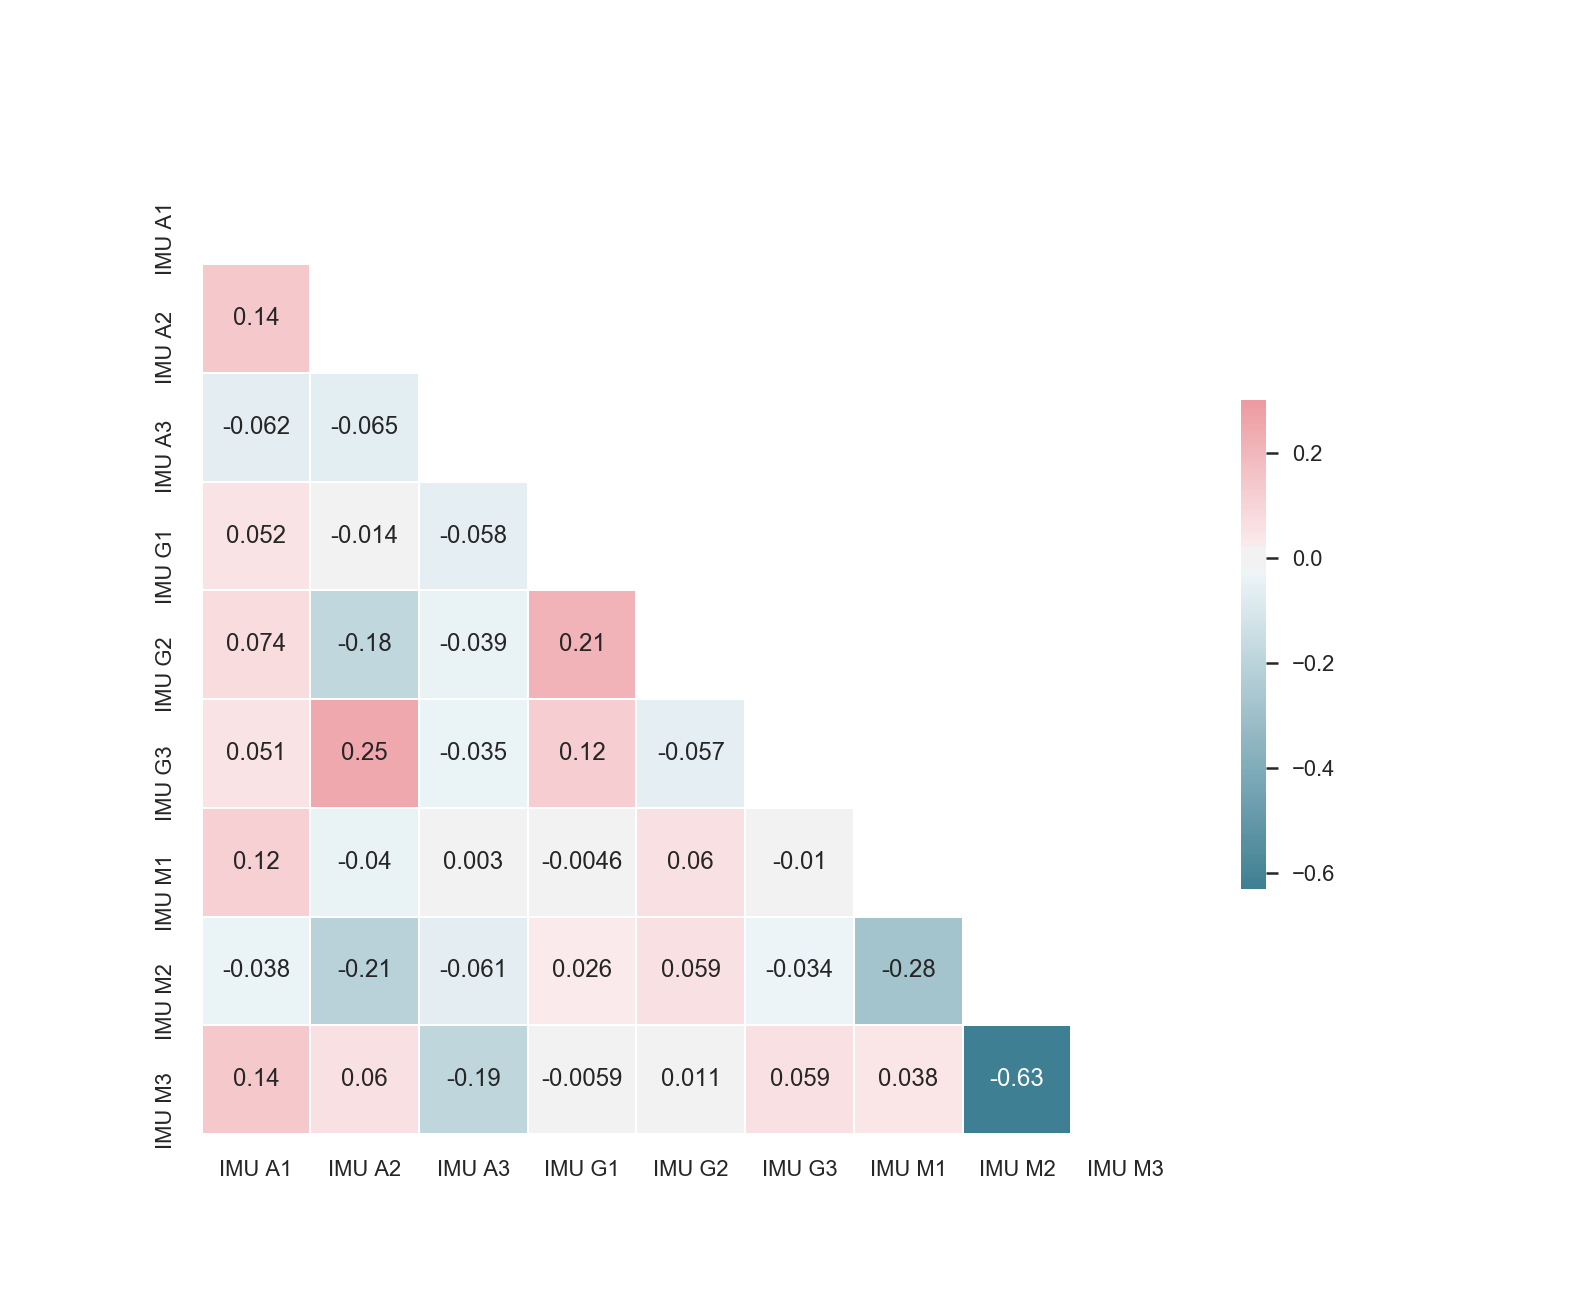

In [352]:
#Display Correlation Features: 
import seaborn as sns

d = simple_multi_dataset
#d = simple_misc_multiclass_df


#Need to bin the data for the correlation matrix: 
#IMU A1 = bin(IMU A1)
#etc.


# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#f,ax = plt.subplots(figsize=(18, 18))
#sns.heatmap(X, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [401]:
#Need to balance labels with SMOTE, ADASYN
from imblearn.over_sampling import SMOTE, ADASYN

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)


#sm = SMOTE(sampling_strategy='all', random_state=12, ratio=1.0)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train)  #oversample on only the training data, after splitting the data initially into training and testing sets

#X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
#_train_res, y_train_res = ADASYN().fit_resample(X_train, y_train)


print(X_train_res.shape)
print(y_train_res.shape)

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y in y_train_res: 
    if y == "FLOATING":
        count_y_float+=1
    if y == "PADDLING":
        count_y_paddle+=1
    if y == "SURFING":
        count_y_surf+=1
        
print(count_y_float)
print(count_y_paddle)
print(count_y_surf)


print("Done")


(11694, 10)
(11694,)
3898
3898
3898
Done


## Multinomial Logistic Regression on Unfiltered IMU Signals

In [402]:
 # Train multinomial logistic regression model using SMOTE
from sklearn import linear_model
from sklearn import metrics

#Using SMOTE: 
print("Using SMOTE: \n")
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train_res, y_train_res)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train_res, mul_lr.predict(X_train_res)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
    
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING"])
#cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING", "MISC"])
print("When printing the confusion matrix, the diaganols tell us the number of correct predictions.") 
print(cm)
    

#Print score:
from sklearn.model_selection import cross_val_score
print(mul_lr.score(X_test, y_test))

#cm.poof()



Using SMOTE: 

Multinomial Logistic regression Train Accuracy ::  0.6067213955874807
Multinomial Logistic regression Test Accuracy ::  0.6203288490284006
When printing the confusion matrix, the diaganols tell us the number of correct predictions.
[[263  59  92]
 [ 53 136  41]
 [  8   1  16]]
0.6203288490284006


In [403]:
 # Train multinomial logistic regression model *without* using SMOTE

#print("\nNot using SMOTE: \n")
#mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)
#print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
#print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING"])
#cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING", "MISC"])

print("When printing the confusion matrix, the diaganols tell us the number of correct predictions.") 
print(cm)

#Print score:
from sklearn.model_selection import cross_val_score
print(mul_lr.score(X_test, y_test))


When printing the confusion matrix, the diaganols tell us the number of correct predictions.
[[263  59  92]
 [ 53 136  41]
 [  8   1  16]]
0.6203288490284006


In [404]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 10)
print(score)

[0.70588235 0.70588235 0.75       0.79411765 0.59701493 0.72727273
 0.81818182 0.8030303  0.6969697  0.72727273]


In [409]:
print("Average score from confusion matrix:")
print(sum(score)/len(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Average score from confusion matrix:
0.7325624551041584
Accuracy: 0.73 (+/- 0.12)
